# IMPORTS

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import cv2
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
import torch.nn as nn
import timm
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import logging
import warnings
import time
from collections import defaultdict
import random

warnings.filterwarnings("ignore")

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)


# DATA LOADING AND VALIDATION

## DATA LOADING

In [ ]:
class DatasetLoader:
    """
    Handles dataset loading and validation for the crop Classification project.

    Attributes:
        drive_path (str): Path to the Google Drive folder
        dataset_name (str): Name of the dataset zip file
        extract_path (str): Path where dataset will be extracted
    """

    def __init__(self):
        # Initialize paths
        self.drive_path = '/content/drive/MyDrive/Plant Disease Identification'
        self.dataset_name = 'Dataset.zip'
        self.extract_base = '/content/dataset'
        self.dataset_root = os.path.join(self.extract_base, 'Dataset')  

        # Full paths after extraction - updated to include Dataset folder
        self.paths = {
            'zip_file': os.path.join(self.drive_path, self.dataset_name),
            'train_dir': os.path.join(self.dataset_root, 'Train'),
            'test_seen_dir': os.path.join(self.dataset_root, 'Test_Seen'),
            'test_unseen_dir': os.path.join(self.dataset_root, 'Test_Unseen'),
            'pd_test_unseen_dir': os.path.join(self.dataset_root, 'PD_Test_Unseen'),
            'train_labels': os.path.join(self.dataset_root, 'Train_labels.csv'),
            'test_seen_labels': os.path.join(self.dataset_root, 'Test_Seen_labels.csv'),
            'test_unseen_labels': os.path.join(self.dataset_root, 'Test_Unseen_labels.csv'),
            'pd_test_unseen_labels': os.path.join(self.dataset_root, 'PD_Test_Unseen_labels.csv')
        }

    def mount_drive(self) -> bool:
        """Mount Google Drive."""
        try:
            logger.info("Mounting Google Drive...")
            from google.colab import drive
            if not os.path.exists('/content/drive'):
                drive.mount('/content/drive')
            return True
        except Exception as e:
            logger.error(f"Failed to mount drive: {str(e)}")
            return False

    def extract_dataset(self) -> bool:
        """Extract dataset from zip file."""
        try:
            if not os.path.exists(self.paths['zip_file']):
                raise FileNotFoundError(f"Dataset zip not found at {self.paths['zip_file']}")

            # Clear existing extraction directory if it exists
            if os.path.exists(self.extract_base):
                logger.info("Removing existing dataset directory...")
                import shutil
                shutil.rmtree(self.extract_base)

            # Create fresh extraction directory
            logger.info("Creating extraction directory...")
            os.makedirs(self.extract_base, exist_ok=True)

            # Extract and log the process
            logger.info("Extracting dataset...")
            with zipfile.ZipFile(self.paths['zip_file'], 'r') as zip_ref:
                zip_ref.extractall(self.extract_base)

            # Verify extraction
            if os.path.exists(self.dataset_root):
                logger.info(f"Extraction successful. Contents of {self.dataset_root}:")
                for item in os.listdir(self.dataset_root):
                    logger.info(f"- {item}")
            else:
                logger.error(f"Dataset root directory not found at {self.dataset_root}")
                return False

            return True
        except Exception as e:
            logger.error(f"Failed to extract dataset: {str(e)}")
            return False

    def validate_dataset(self) -> Dict[str, Dict[str, any]]:
        """
        Validate the extracted dataset structure and contents.

        Returns:
            Dictionary containing validation results for each component
        """
        validation = {
            'directories': {
                'train': {'exists': False, 'count': 0},
                'test_seen': {'exists': False, 'count': 0},
                'test_unseen': {'exists': False, 'count': 0},
                'pd_test_unseen': {'exists': False, 'count': 0}
            },
            'labels': {
                'train': {'exists': False, 'size': 0},
                'test_seen': {'exists': False, 'size': 0},
                'test_unseen': {'exists': False, 'size': 0},
                'pd_test_unseen': {'exists': False, 'size': 0}
            }
        }

        # Log the contents of the dataset root
        if os.path.exists(self.dataset_root):
            logger.info(f"Contents of dataset root ({self.dataset_root}):")
            for item in os.listdir(self.dataset_root):
                logger.info(f"- {item}")

        # Validate directories and count images
        dir_pairs = [
            ('train', 'train_dir'),
            ('test_seen', 'test_seen_dir'),
            ('test_unseen', 'test_unseen_dir'),
            ('pd_test_unseen', 'pd_test_unseen_dir')
        ]

        for key, path_key in dir_pairs:
            path = self.paths[path_key]
            if os.path.exists(path):
                validation['directories'][key]['exists'] = True
                validation['directories'][key]['count'] = len([
                    f for f in os.listdir(path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ])
                logger.info(f"Found {validation['directories'][key]['count']} images in {path}")

        # Validate label files
        label_pairs = [
            ('train', 'train_labels'),
            ('test_seen', 'test_seen_labels'),
            ('test_unseen', 'test_unseen_labels'),
            ('pd_test_unseen', 'pd_test_unseen_labels')
        ]

        for key, path_key in label_pairs:
            path = self.paths[path_key]
            if os.path.exists(path):
                validation['labels'][key]['exists'] = True
                validation['labels'][key]['size'] = os.path.getsize(path)
                logger.info(f"Found label file: {path} ({validation['labels'][key]['size']} bytes)")

        return validation

    def print_validation_results(self, validation: Dict) -> None:
        """Print formatted validation results."""
        print("\nDataset Validation Results:")
        print("-" * 50)

        print("\nDirectories:")
        for dir_key in ['train', 'test_seen', 'test_unseen', 'pd_test_unseen']:
            exists = validation['directories'][dir_key]['exists']
            count = validation['directories'][dir_key]['count']
            print(f"{dir_key.replace('_', ' ').title()} Directory: {'✓' if exists else '✗'}")
            print(f"├── Image Count: {count}")

        print("\nLabel Files:")
        for label_key in ['train', 'test_seen', 'test_unseen', 'pd_test_unseen']:
            exists = validation['labels'][label_key]['exists']
            size = validation['labels'][label_key]['size']
            print(f"{label_key.replace('_', ' ').title()} Labels: {'✓' if exists else '✗'} ({size} bytes)")

        print("\nPath Information:")
        print(f"Extraction Base: {self.extract_base}")
        print(f"Dataset Root: {self.dataset_root}")
        for key, path in self.paths.items():
            exists = os.path.exists(path)
            print(f"{key}: {'✓' if exists else '✗'} ({path})")

    def setup(self) -> Tuple[bool, Dict]:
        """
        Complete dataset setup process.

        Returns:
            Tuple containing success status and validation results
        """
        import os
        import zipfile
        import logging as logger
        from typing import Dict, Tuple

        # Mount drive
        if not self.mount_drive():
            return False, {}

        # Extract dataset
        if not self.extract_dataset():
            return False, {}

        # Validate dataset
        validation_results = self.validate_dataset()
        self.print_validation_results(validation_results)

        # Check if all components are present
        setup_success = all([
            validation_results['directories'][key]['exists'] and
            validation_results['directories'][key]['count'] > 0
            for key in ['train', 'test_seen', 'test_unseen', 'pd_test_unseen']
        ]) and all([
            validation_results['labels'][key]['exists']
            for key in ['train', 'test_seen', 'test_unseen', 'pd_test_unseen']
        ])

        if not setup_success:
            logger.warning("Dataset setup incomplete - some components are missing")
        else:
            logger.info("Dataset setup completed successfully")

        return setup_success, validation_results

# Execute the setup
loader = DatasetLoader()
success, validation = loader.setup()

# If successful, make paths easily accessible
if success:
    TRAIN_DIR = loader.paths['train_dir']
    TEST_SEEN_DIR = loader.paths['test_seen_dir']
    TEST_UNSEEN_DIR = loader.paths['test_unseen_dir']
    PD_TEST_UNSEEN_DIR = loader.paths['pd_test_unseen_dir']
    TRAIN_LABELS = loader.paths['train_labels']
    TEST_SEEN_LABELS = loader.paths['test_seen_labels']
    TEST_UNSEEN_LABELS = loader.paths['test_unseen_labels']
    PD_TEST_UNSEEN_LABELS = loader.paths['pd_test_unseen_labels']
    print("\nPaths are now ready for use in subsequent steps")
else:
    print("\nWARNING: Setup incomplete - please check the validation results above")

Mounted at /content/drive

Dataset Validation Results:
--------------------------------------------------

Directories:
Train Directory: ✓
├── Image Count: 7316
Test Seen Directory: ✓
├── Image Count: 1836
Test Unseen Directory: ✓
├── Image Count: 50
Pd Test Unseen Directory: ✓
├── Image Count: 71

Label Files:
Train Labels: ✓ (457482 bytes)
Test Seen Labels: ✓ (114701 bytes)
Test Unseen Labels: ✓ (3238 bytes)
Pd Test Unseen Labels: ✓ (2424 bytes)

Path Information:
Extraction Base: /content/dataset
Dataset Root: /content/dataset/Dataset
zip_file: ✓ (/content/drive/MyDrive/Plant Disease Identification/Dataset.zip)
train_dir: ✓ (/content/dataset/Dataset/Train)
test_seen_dir: ✓ (/content/dataset/Dataset/Test_Seen)
test_unseen_dir: ✓ (/content/dataset/Dataset/Test_Unseen)
pd_test_unseen_dir: ✓ (/content/dataset/Dataset/PD_Test_Unseen)
train_labels: ✓ (/content/dataset/Dataset/Train_labels.csv)
test_seen_labels: ✓ (/content/dataset/Dataset/Test_Seen_labels.csv)
test_unseen_labels: ✓ (/cont

## IMAGE PROCESSING

In [3]:
class ImageProcessor:
    """Handles image validation and preprocessing."""

    @staticmethod
    def validate_and_resize_images(directory: str, target_size: Tuple[int, int] = (224, 224)) -> Dict:
        stats = {'total': 0, 'processed': 0, 'errors': 0}

        # Look for images with different extensions
        extensions = ('*.jpg', '*.JPG')

        # Collect all image paths first
        all_image_paths = []
        for ext in extensions:
            all_image_paths.extend(Path(directory).rglob(ext))

        # Update total count
        stats['total'] = len(all_image_paths)

        # Process images with a progress bar for the total count
        for img_path in tqdm(all_image_paths, desc=f"Processing images in {Path(directory).name}"):
            try:
                with Image.open(img_path) as img:
                    if img.size != target_size:
                        img = img.convert('RGB')
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(img_path, quality=95, format='JPEG')
                        stats['processed'] += 1
            except Exception as e:
                stats['errors'] += 1
                logger.error(f"Error processing {img_path}: {str(e)}")

        print(f"\nDirectory {Path(directory).name}:")
        print(f"Total images: {stats['total']}")
        print(f"Processed: {stats['processed']}")
        print(f"Errors: {stats['errors']}")

        return stats

    @staticmethod
    def process_all_directories(train_dir: str, test_seen_dir: str, test_unseen_dir: str, pd_test_unseen_dir: str,
                              target_size: Tuple[int, int] = (224, 224)) -> Dict[str, Dict]:
        """
        Process all image directories in the dataset.

        Args:
            train_dir: Path to training images
            test_seen_dir: Path to test seen images
            test_unseen_dir: Path to test unseen images
            target_size: Target size for image resizing
        """
        print("\nProcessing all image directories...")

        results = {
            'train': ImageProcessor.validate_and_resize_images(train_dir, target_size),
            'test_seen': ImageProcessor.validate_and_resize_images(test_seen_dir, target_size),
            'test_unseen': ImageProcessor.validate_and_resize_images(test_unseen_dir, target_size),
            'pd_test_unseen': ImageProcessor.validate_and_resize_images(pd_test_unseen_dir, target_size)
        }

        # Print summary of all processing
        print("\nOverall Processing Summary:")
        print("-" * 50)
        total_images = sum(result['total'] for result in results.values())
        total_processed = sum(result['processed'] for result in results.values())
        total_errors = sum(result['errors'] for result in results.values())

        print(f"Total images across all directories: {total_images}")
        print(f"Total images processed: {total_processed}")
        print(f"Total errors encountered: {total_errors}")

        return results

# After running DatasetLoader, process all image directories
if success:  # Using the success variable from DatasetLoader
    processing_results = ImageProcessor.process_all_directories(
        train_dir=TRAIN_DIR,
        test_seen_dir=TEST_SEEN_DIR,
        test_unseen_dir=TEST_UNSEEN_DIR,
        pd_test_unseen_dir=PD_TEST_UNSEEN_DIR
    )
else:
    print("Please ensure dataset is properly loaded before processing images.")


Processing all image directories...


Processing images in Train:   0%|          | 0/7316 [00:00<?, ?it/s]


Directory Train:
Total images: 7316
Processed: 7316
Errors: 0


Processing images in Test_Seen:   0%|          | 0/1836 [00:00<?, ?it/s]


Directory Test_Seen:
Total images: 1836
Processed: 1836
Errors: 0


Processing images in Test_Unseen:   0%|          | 0/50 [00:00<?, ?it/s]


Directory Test_Unseen:
Total images: 50
Processed: 50
Errors: 0


Processing images in PD_Test_Unseen:   0%|          | 0/71 [00:00<?, ?it/s]


Directory PD_Test_Unseen:
Total images: 71
Processed: 71
Errors: 0

Overall Processing Summary:
--------------------------------------------------
Total images across all directories: 9273
Total images processed: 9273
Total errors encountered: 0


## LABEL PROCESSING


Processing train dataset...
Labels: /content/dataset/Dataset/Train_labels.csv
Images: /content/dataset/Dataset/Train


Processing labels:   0%|          | 0/7316 [00:00<?, ?it/s]


Processed 7316 valid image-label pairs

Sample of processed data:
                                          image_name  crop  disease  \
0  1b7e4b68-0062-410d-a57f-48177145dfb6___RS_HL-7...     0        0   
1  d990e148-621b-4e71-8a8c-9b71c15f7faf___RS_HL-8...     0        0   
2  ea45b7c8-f1c2-42c0-bfec-96444c58ddd0___RS_HL-6...     0        0   
3  8acb2f43-d1ff-4a60-8462-04e578be3be2___RS_HL-7...     0        0   
4  375f1e44-235c-4ef0-a156-077b71abeed3___RS_HL-8...     0        0   

                                           full_path  
0  /content/dataset/Dataset/Train/1b7e4b68-0062-4...  
1  /content/dataset/Dataset/Train/d990e148-621b-4...  
2  /content/dataset/Dataset/Train/ea45b7c8-f1c2-4...  
3  /content/dataset/Dataset/Train/8acb2f43-d1ff-4...  
4  /content/dataset/Dataset/Train/375f1e44-235c-4...  

-------------------- Train_labels Dataset Analysis --------------------

Total Samples: 7316
Unique Crops: 14
Unique Diseases: 21


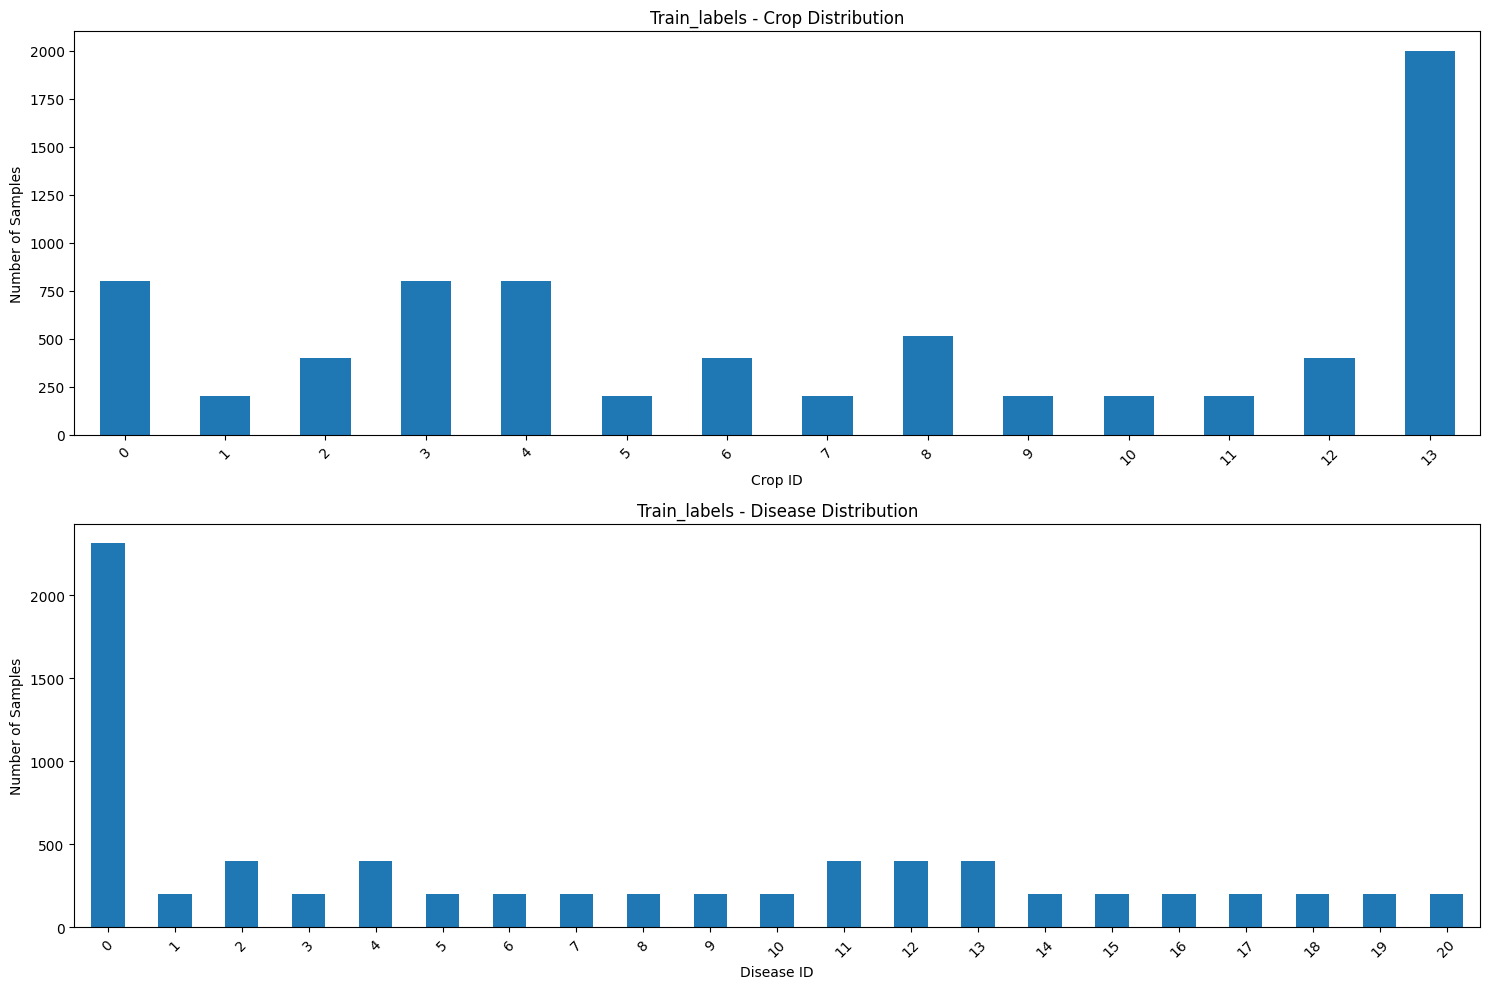

Processing labels:   0%|          | 0/1836 [00:00<?, ?it/s]

Successfully processed 7316 samples for train

Processing test_seen dataset...
Labels: /content/dataset/Dataset/Test_Seen_labels.csv
Images: /content/dataset/Dataset/Test_Seen

Processed 1836 valid image-label pairs

Sample of processed data:
                                          image_name  crop  disease  \
0  4da8c9ec-92d1-4e33-87b2-de2906f88a46___RS_HL-8...     0        0   
1  a117c853-363a-443a-b489-323fb4239f07___RS_HL-5...     0        0   
2  5e552830-5ccd-4f85-9f77-ed63db285890___RS_HL-5...     0        0   
3  b34b807c-4986-4b85-8ede-73d625a14921___RS_HL-8...     0        0   
4  56c8fb12-185b-4225-bdee-abdbdcc6101b___RS_HL-7...     0        0   

                                           full_path  
0  /content/dataset/Dataset/Test_Seen/4da8c9ec-92...  
1  /content/dataset/Dataset/Test_Seen/a117c853-36...  
2  /content/dataset/Dataset/Test_Seen/5e552830-5c...  
3  /content/dataset/Dataset/Test_Seen/b34b807c-49...  
4  /content/dataset/Dataset/Test_Seen/56c8fb12-18...  


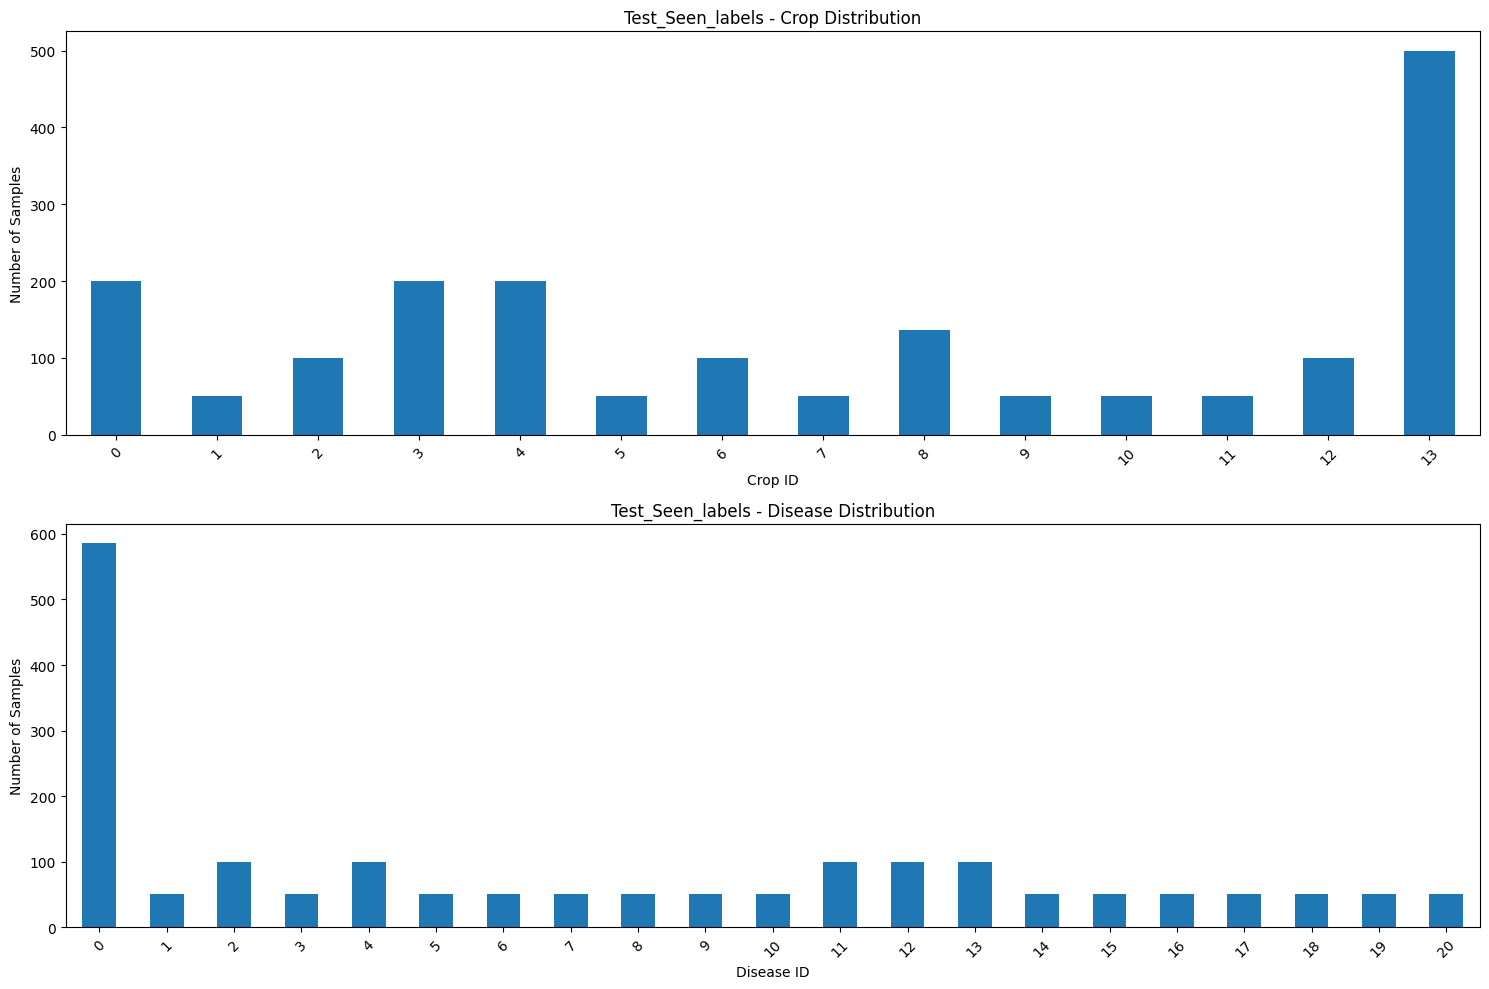

Successfully processed 1836 samples for test_seen

Processing test_unseen dataset...
Labels: /content/dataset/Dataset/Test_Unseen_labels.csv
Images: /content/dataset/Dataset/Test_Unseen


Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]


Processed 50 valid image-label pairs

Sample of processed data:
                                          image_name  crop  disease  \
0  4396fc84-fea6-4cfd-a352-01241e44efda___NREC_B....     7       11   
1  a32c2976-7ef3-4dfa-95d8-c3c056b36012___JR_B.Sp...     7       11   
2  23e657c9-1f08-4714-817b-48fd2f3e2cf3___JR_B.Sp...     7       11   
3  62ff339a-6883-4d8f-b7e3-913c1b950c38___JR_B.Sp...     7       11   
4  179067a6-1012-4a23-8f09-e413300e9f32___NREC_B....     7       11   

                                           full_path  
0  /content/dataset/Dataset/Test_Unseen/4396fc84-...  
1  /content/dataset/Dataset/Test_Unseen/a32c2976-...  
2  /content/dataset/Dataset/Test_Unseen/23e657c9-...  
3  /content/dataset/Dataset/Test_Unseen/62ff339a-...  
4  /content/dataset/Dataset/Test_Unseen/179067a6-...  

-------------------- Test_Unseen_labels Dataset Analysis --------------------

Total Samples: 50
Unique Crops: 1
Unique Diseases: 1


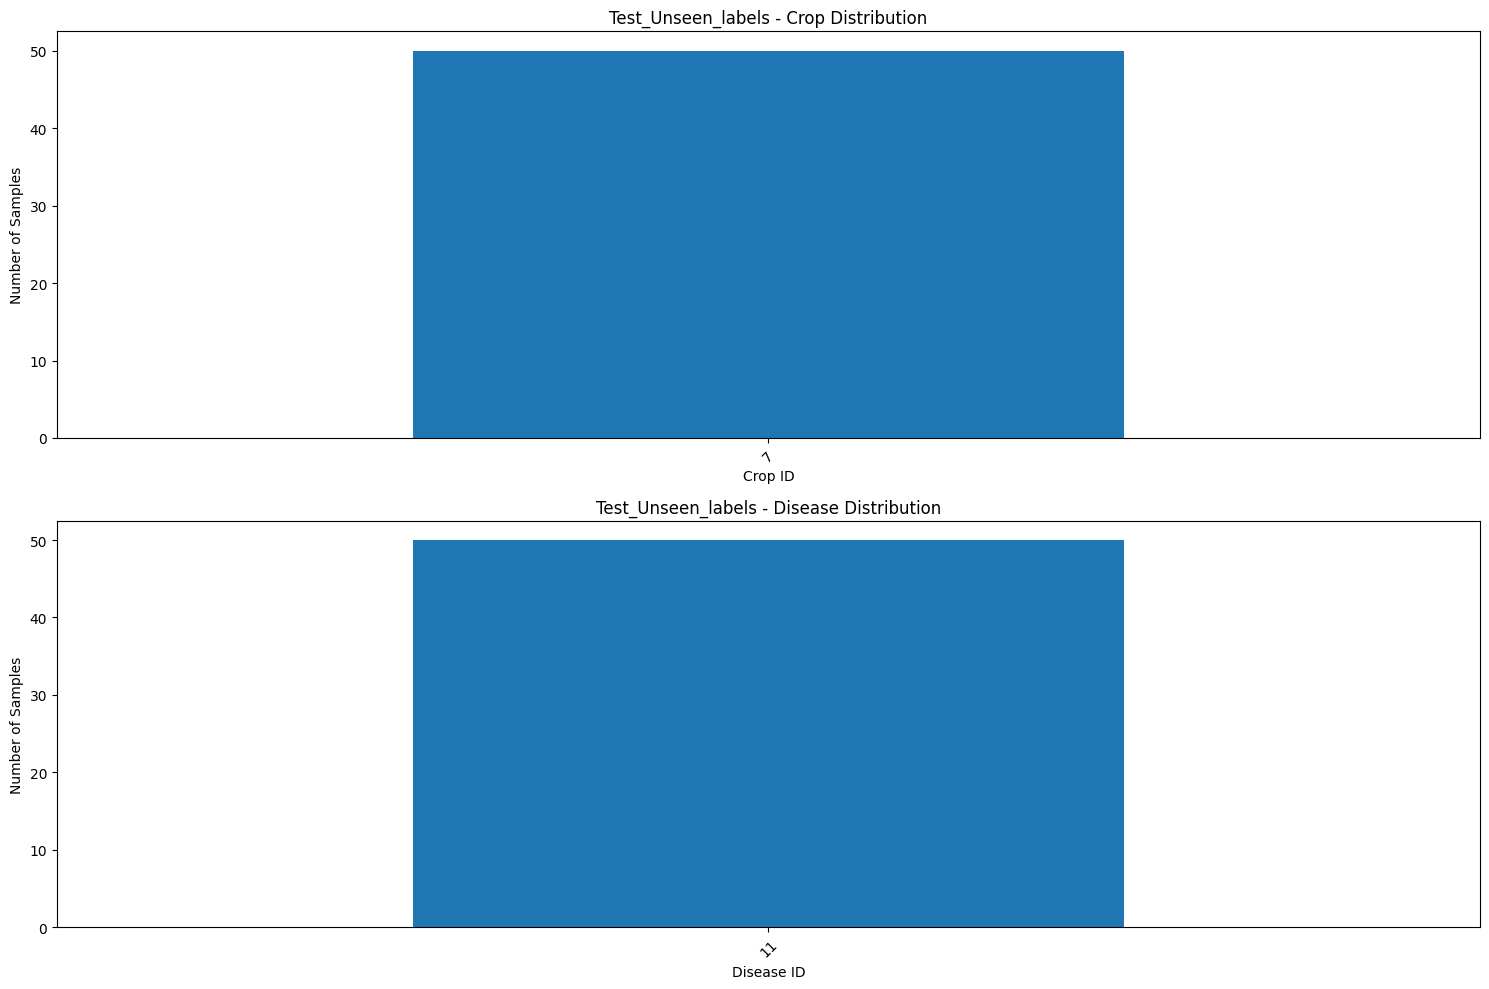

Successfully processed 50 samples for test_unseen

Processing pd_test_unseen dataset...
Labels: /content/dataset/Dataset/PD_Test_Unseen_labels.csv
Images: /content/dataset/Dataset/PD_Test_Unseen


Processing labels:   0%|          | 0/71 [00:00<?, ?it/s]


Processed 71 valid image-label pairs

Sample of processed data:
  image_name  crop  disease                                         full_path
0      0.jpg     7       11     /content/dataset/Dataset/PD_Test_Unseen/0.jpg
1     00.jpg     7       11    /content/dataset/Dataset/PD_Test_Unseen/00.jpg
2    000.jpg     7       11   /content/dataset/Dataset/PD_Test_Unseen/000.jpg
3   0000.jpg     7       11  /content/dataset/Dataset/PD_Test_Unseen/0000.jpg
4     01.jpg     7       11    /content/dataset/Dataset/PD_Test_Unseen/01.jpg

-------------------- PD_Test_Unseen_labels Dataset Analysis --------------------

Total Samples: 71
Unique Crops: 1
Unique Diseases: 1


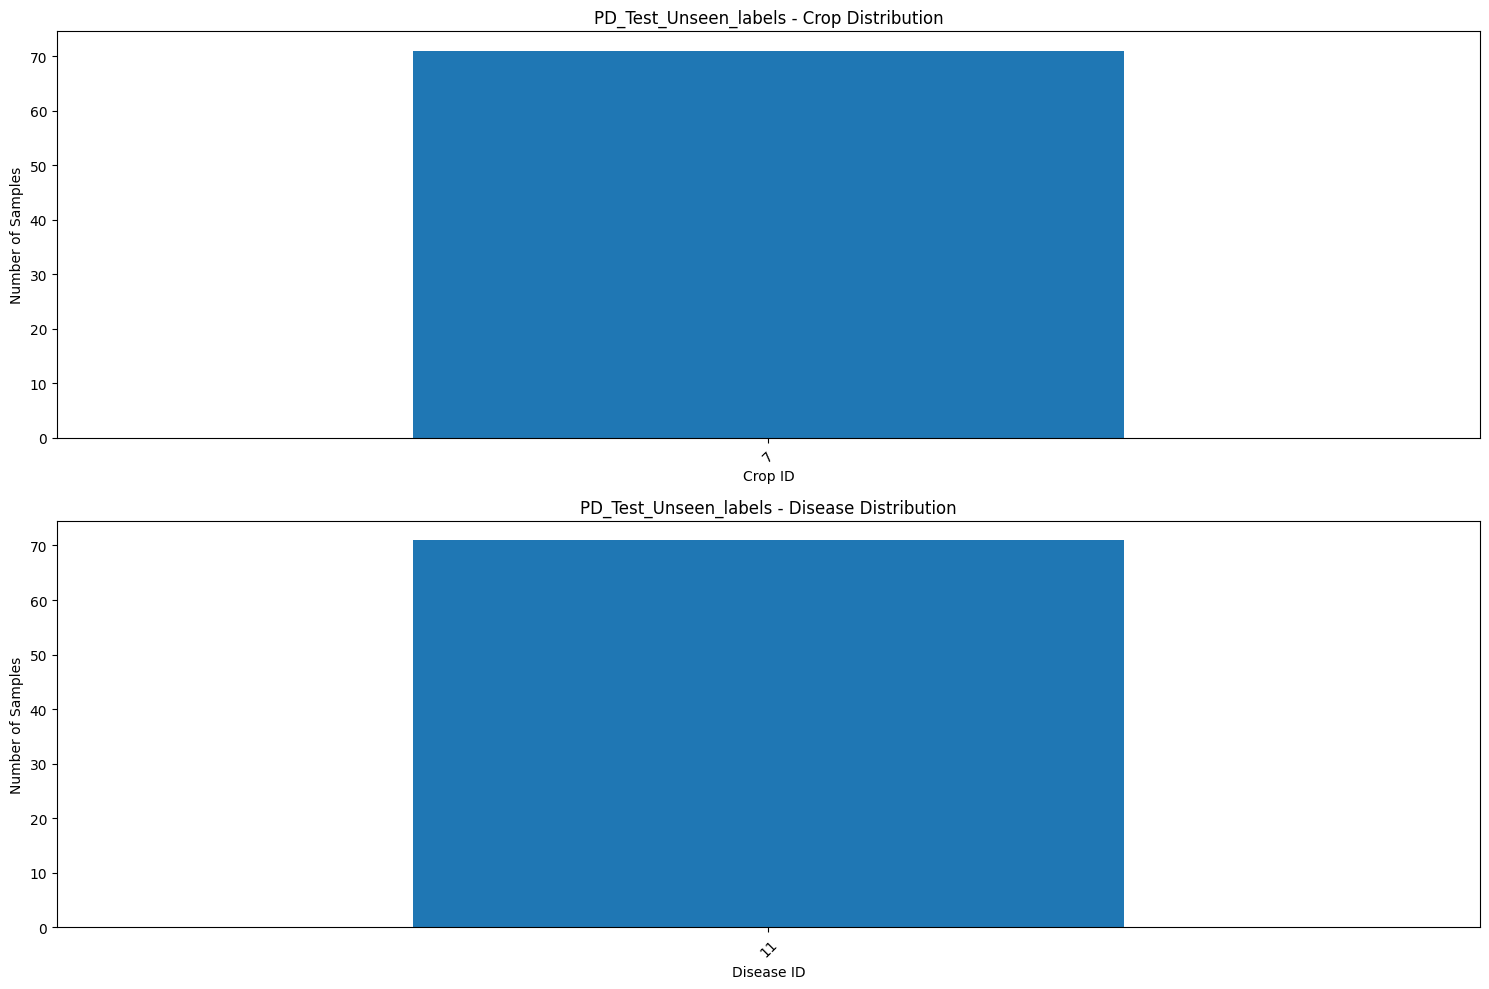

Successfully processed 71 samples for pd_test_unseen

train dataset:
Total samples: 7316
Unique crops: 14
Unique diseases: 21

test_seen dataset:
Total samples: 1836
Unique crops: 14
Unique diseases: 21

test_unseen dataset:
Total samples: 50
Unique crops: 1
Unique diseases: 1

pd_test_unseen dataset:
Total samples: 71
Unique crops: 1
Unique diseases: 1


In [ ]:
class LabelAnalyzer:
    """Analyzes and verifies label distribution in datasets."""

    @staticmethod
    def analyze_labels(dataframe: pd.DataFrame, name: str) -> Dict[str, Dict]:
        """Analyze crop and disease label distributions."""
        if dataframe.empty:
            logger.warning(f"\n{name}: No valid data found for analysis")
            return {}

        analysis_stats = {
            'general': {},
            'crops': {},
            'diseases': {},
            'combinations': {}
        }

        try:
            # Basic dataset statistics
            analysis_stats['general'] = {
                'total_samples': len(dataframe),
                'unique_crops': dataframe['crop'].nunique(),
                'unique_diseases': dataframe['disease'].nunique()
            }

            # Analyze crop labels
            crop_counts = dataframe['crop'].value_counts().sort_index()
            analysis_stats['crops'] = {
                'distribution': crop_counts.to_dict(),
                'stats': {
                    'min_samples': crop_counts.min(),
                    'max_samples': crop_counts.max(),
                    'mean_samples': crop_counts.mean(),
                    'median_samples': crop_counts.median()
                }
            }

            # Analyze disease labels
            disease_counts = dataframe['disease'].value_counts().sort_index()
            analysis_stats['diseases'] = {
                'distribution': disease_counts.to_dict(),
                'stats': {
                    'min_samples': disease_counts.min(),
                    'max_samples': disease_counts.max(),
                    'mean_samples': disease_counts.mean(),
                    'median_samples': disease_counts.median()
                }
            }

            # Print analysis results
            print(f"\n{'-'*20} {name} Dataset Analysis {'-'*20}")
            print(f"\nTotal Samples: {analysis_stats['general']['total_samples']}")
            print(f"Unique Crops: {analysis_stats['general']['unique_crops']}")
            print(f"Unique Diseases: {analysis_stats['general']['unique_diseases']}")

            # Create visualizations
            plt.figure(figsize=(15, 10))

            # Plot crop distribution
            plt.subplot(2, 1, 1)
            crop_counts.plot(kind='bar')
            plt.title(f'{name} - Crop Distribution')
            plt.xlabel('Crop ID')
            plt.ylabel('Number of Samples')
            plt.xticks(rotation=45)

            # Plot disease distribution
            plt.subplot(2, 1, 2)
            disease_counts.plot(kind='bar')
            plt.title(f'{name} - Disease Distribution')
            plt.xlabel('Disease ID')
            plt.ylabel('Number of Samples')
            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

            return analysis_stats

        except Exception as e:
            logger.error(f"Error in analyze_labels: {str(e)}")
            import traceback
            logger.error(f"Traceback: {traceback.format_exc()}")
            return {}

class LabelProcessor:
    """Handles label validation and processing."""

    @staticmethod
    def process_labels(csv_path: str, img_dir: str) -> pd.DataFrame:
        """Process and validate labels with image existence verification."""
        try:
            # Verify paths exist
            if not os.path.exists(csv_path):
                logger.error(f"CSV file not found: {csv_path}")
                return pd.DataFrame()
            if not os.path.exists(img_dir):
                logger.error(f"Image directory not found: {img_dir}")
                return pd.DataFrame()

            # Read the CSV file content
            with open(csv_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]

            # Process the data
            processed_data = []
            for line in tqdm(lines, desc="Processing labels"):
                try:
                    # Split the line and handle potential extra commas in image name
                    parts = line.split(',')
                    if len(parts) < 3:
                        continue

                    # The image name might contain commas, so join all parts except last 2
                    image_parts = parts[:-2]
                    image_name = ','.join(image_parts).strip()

                    # Get the labels from the last two parts
                    try:
                        crop_id = int(parts[-2])
                        disease_id = int(parts[-1])
                    except ValueError:
                        continue

                    # Check if image exists
                    actual_image_name = None
                    possible_extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG']
                    base_name = os.path.splitext(image_name)[0]

                    for ext in possible_extensions:
                        test_path = os.path.join(img_dir, base_name + ext)
                        if os.path.exists(test_path):
                            actual_image_name = base_name + ext
                            break

                    if actual_image_name:
                        processed_data.append({
                            'image_name': actual_image_name,
                            'crop': crop_id,
                            'disease': disease_id,
                            'full_path': os.path.join(img_dir, actual_image_name)
                        })

                except Exception as e:
                    logger.warning(f"Error processing line: {line}, Error: {str(e)}")
                    continue

            # Create DataFrame
            df = pd.DataFrame(processed_data)

            if df.empty:
                logger.error("No valid data could be processed")
                return pd.DataFrame()

            # Verify all images exist
            valid_files = df['full_path'].apply(os.path.exists)
            valid_df = df[valid_files].copy()

            if len(valid_df) == 0:
                logger.error("No valid image-label pairs found")
                return pd.DataFrame()

            print(f"\nProcessed {len(valid_df)} valid image-label pairs")
            print("\nSample of processed data:")
            print(valid_df.head())

            # Analyze label distribution
            LabelAnalyzer.analyze_labels(valid_df, Path(csv_path).stem)

            return valid_df

        except Exception as e:
            logger.error(f"Error in process_labels: {str(e)}")
            import traceback
            logger.error(f"Traceback: {traceback.format_exc()}")
            return pd.DataFrame()

    @staticmethod
    def process_all_datasets(train_labels: str, test_seen_labels: str, test_unseen_labels: str, pd_test_unseen_labels: str,
                           train_dir: str, test_seen_dir: str, test_unseen_dir: str, pd_test_unseen_dir) -> Dict[str, pd.DataFrame]:
        """Process all datasets and return their DataFrames."""

        datasets = {
            'train': (train_labels, train_dir),
            'test_seen': (test_seen_labels, test_seen_dir),
            'test_unseen': (test_unseen_labels, test_unseen_dir),
            'pd_test_unseen': (pd_test_unseen_labels, pd_test_unseen_dir)
        }

        processed_data = {}

        for name, (label_path, img_dir) in datasets.items():
            print(f"\nProcessing {name} dataset...")
            print(f"Labels: {label_path}")
            print(f"Images: {img_dir}")

            processed_data[name] = LabelProcessor.process_labels(label_path, img_dir)

            if processed_data[name].empty:
                print(f"No valid samples processed for {name}")
            else:
                print(f"Successfully processed {len(processed_data[name])} samples for {name}")

        return processed_data

# Process all datasets
processed_datasets = LabelProcessor.process_all_datasets(
    train_labels=TRAIN_LABELS,
    test_seen_labels=TEST_SEEN_LABELS,
    test_unseen_labels=TEST_UNSEEN_LABELS,
    pd_test_unseen_labels=PD_TEST_UNSEEN_LABELS,
    train_dir=TRAIN_DIR,
    test_seen_dir=TEST_SEEN_DIR,
    test_unseen_dir=TEST_UNSEEN_DIR,
    pd_test_unseen_dir=PD_TEST_UNSEEN_DIR
)

# Access individual datasets
train_df = processed_datasets['train']
test_seen_df = processed_datasets['test_seen']
test_unseen_df = processed_datasets['test_unseen']
pd_test_unseen_df = processed_datasets['pd_test_unseen']

# Print summary
for name, df in processed_datasets.items():
    if not df.empty:
        print(f"\n{name} dataset:")
        print(f"Total samples: {len(df)}")
        print(f"Unique crops: {df['crop'].nunique()}")
        print(f"Unique diseases: {df['disease'].nunique()}")


# DATA PREPARATION

## DATASET CLASS

In [ ]:
class CropDiseaseDataset(Dataset):
    """Custom Dataset for crop disease classification with support for seen/unseen test sets."""

    def __init__(self,
                 data: pd.DataFrame,
                 transform: Optional[transforms.Compose] = None,
                 mode: str = 'train',
                 is_unseen: bool = False):
        """
        Initialize dataset.

        Args:
            data: DataFrame containing image paths and labels
            transform: Optional transforms to be applied
            mode: Dataset mode ('train', 'val', 'test_seen', or 'test_unseen')
            is_unseen: Flag indicating if this is an unseen test set
        """
        self.data = data.copy()
        self.transform = transform
        self.mode = mode
        self.is_unseen = is_unseen

        # Validate dataset
        self.validate_dataset()

    def validate_dataset(self) -> None:
        """Validate dataset structure and analyze distributions."""
        try:
            # Basic validation
            required_columns = ['image_name', 'crop', 'disease', 'full_path']
            assert all(col in self.data.columns for col in required_columns), "Missing required columns"

            # Path validation
            invalid_paths = self.data['full_path'].apply(lambda x: not os.path.exists(x))
            if invalid_paths.any():
                logger.warning(f"Found {invalid_paths.sum()} invalid image paths in {self.mode} set")
                self.data = self.data[~invalid_paths].reset_index(drop=True)

            # Distribution analysis
            if self.mode == 'test_unseen':
                self._validate_unseen_distribution()
            else:
                self._validate_seen_distribution()

        except Exception as e:
            logger.error(f"Dataset validation failed for {self.mode}: {str(e)}")
            raise

    def _validate_seen_distribution(self) -> None:
        """Validate and analyze distribution for seen data."""
        print(f"\n{'-'*20} {self.mode} Dataset Statistics {'-'*20}")
        print(f"Total samples: {len(self.data)}")

        # Analyze crop distribution
        crop_dist = self.data['crop'].value_counts()
        print("\nCrop Distribution:")
        print(f"Unique crops: {len(crop_dist)}")
        print(f"Samples per crop - Min: {crop_dist.min()}, Max: {crop_dist.max()}, Mean: {crop_dist.mean():.2f}")
        print("\nTop 5 crops by frequency:")
        print(crop_dist.head())

        # Analyze disease distribution
        disease_dist = self.data['disease'].value_counts()
        print("\nDisease Distribution:")
        print(f"Unique diseases: {len(disease_dist)}")
        print(f"Samples per disease - Min: {disease_dist.min()}, Max: {disease_dist.max()}, Mean: {disease_dist.mean():.2f}")
        print("\nTop 5 diseases by frequency:")
        print(disease_dist.head())

        # Analyze crop-disease combinations
        combinations = self.data.groupby(['crop', 'disease']).size()
        print(f"\nUnique crop-disease combinations: {len(combinations)}")
        print("\nTop 5 crop-disease combinations:")
        print(combinations.sort_values(ascending=False).head())

    def _validate_unseen_distribution(self) -> None:
        """Validate and analyze distribution for unseen test data."""
        print(f"\n{'-'*20} Unseen Test Dataset Statistics {'-'*20}")
        print(f"Total samples: {len(self.data)}")

        # Analyze distributions with focus on unseen combinations
        crop_dist = self.data['crop'].value_counts()
        disease_dist = self.data['disease'].value_counts()
        combinations = self.data.groupby(['crop', 'disease']).size()

        print(f"\nUnique crops: {len(crop_dist)}")
        print(f"Unique diseases: {len(disease_dist)}")
        print(f"Unique crop-disease combinations: {len(combinations)}")

        # Identify potentially unseen combinations
        print("\nDistribution Summary:")
        print(f"Crops per sample: {len(crop_dist)}")
        print(f"Diseases per sample: {len(disease_dist)}")
        print(f"Average samples per combination: {len(self.data)/len(combinations):.2f}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['full_path']
        crop_label = self.data.iloc[idx]['crop']
        disease_label = self.data.iloc[idx]['disease']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return {
            'image': image,
            'crop_label': crop_label,
            'disease_label': disease_label,
        }

## DATA AUGMENTATION

In [6]:
class DataTransformations:
    """Handles data augmentation and transformations."""

    # Class constants
    IMAGE_SIZE = 224
    RESIZE_SIZE = 256
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    @staticmethod
    def get_transforms(mode: str = 'train') -> transforms.Compose:
        """
        Create transformation pipeline.

        Args:
            mode: 'train' or 'val'/'test'
        """
        # Base transforms for all modes
        base_transforms = [
            transforms.ToTensor(),
            transforms.Normalize(mean=DataTransformations.MEAN,
                              std=DataTransformations.STD)
        ]

        if mode == 'train':
            train_transforms = [
                # Strong augmentation for training
                transforms.RandomResizedCrop(
                    DataTransformations.IMAGE_SIZE,
                    scale=(0.8, 1.0)
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                ),
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.2, 0.2),
                    scale=(0.8, 1.2)
                ),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=3)
                ], p=0.3),  # Optional blur
                *base_transforms
            ]
            return transforms.Compose(train_transforms)
        else:
            val_transforms = [
                transforms.Resize(DataTransformations.RESIZE_SIZE),
                transforms.CenterCrop(DataTransformations.IMAGE_SIZE),
                *base_transforms
            ]
            return transforms.Compose(val_transforms)

    @staticmethod
    def get_inverse_transforms():
        """Get inverse normalization for visualization."""
        return transforms.Compose([
            transforms.Normalize(
                mean=[0., 0., 0.],
                std=[1/s for s in DataTransformations.STD]
            ),
            transforms.Normalize(
                mean=[-m for m in DataTransformations.MEAN],
                std=[1., 1., 1.]
            )
        ])

## DATASET BUILDER

In [7]:
class DatasetBuilder:
    """Handles dataset preparation and validation with explicit seen/unseen test handling."""

    @staticmethod
    def create_datasets(
        processed_data: Dict[str, pd.DataFrame],
        transforms_dict: Optional[Dict[str, transforms.Compose]] = None
    ) -> Dict[str, Dataset]:
        """
        Create datasets with explicit handling of seen and unseen test sets.

        Args:
            processed_data: Dictionary containing DataFrames for each split
            transforms_dict: Optional dictionary of transforms for each split
        """
        if transforms_dict is None:
            transforms_dict = {
                'train': DataTransformations.get_transforms('train'),
                'val': DataTransformations.get_transforms('val'),
                'test': DataTransformations.get_transforms('val')
            }

        datasets = {}

        try:
            # Handle training data
            if 'train' in processed_data and not processed_data['train'].empty:
                logger.info("Processing training data...")

                # Create stratified split
                train_df, val_df = train_test_split(
                    processed_data['train'],
                    test_size=0.2,
                    stratify=processed_data['train'][['crop', 'disease']].apply(tuple, axis=1),
                    random_state=42
                )

                # Create train dataset
                datasets['train'] = CropDiseaseDataset(
                    train_df,
                    transform=transforms_dict['train'],
                    mode='train',
                    is_unseen=False
                )

                # Create validation dataset
                datasets['val'] = CropDiseaseDataset(
                    val_df,
                    transform=transforms_dict['val'],
                    mode='val',
                    is_unseen=False
                )

                logger.info(f"Created training set with {len(datasets['train'])} samples")
                logger.info(f"Created validation set with {len(datasets['val'])} samples")

            # Handle seen test data
            if 'test_seen' in processed_data and not processed_data['test_seen'].empty:
                logger.info("Processing seen test data...")
                datasets['test_seen'] = CropDiseaseDataset(
                    processed_data['test_seen'],
                    transform=transforms_dict['test'],
                    mode='test_seen',
                    is_unseen=False
                )
                logger.info(f"Created seen test set with {len(datasets['test_seen'])} samples")

            # Handle unseen test data
            if 'test_unseen' in processed_data and not processed_data['test_unseen'].empty:
                logger.info("Processing unseen test data...")
                datasets['test_unseen'] = CropDiseaseDataset(
                    processed_data['test_unseen'],
                    transform=transforms_dict['test'],
                    mode='test_unseen',
                    is_unseen=True
                )
                logger.info(f"Created unseen test set with {len(datasets['test_unseen'])} samples")

            # Verify dataset splits and combinations
            DatasetBuilder._verify_dataset_splits(datasets)

            return datasets

        except Exception as e:
            logger.error(f"Error creating datasets: {str(e)}")
            raise

    @staticmethod
    def _verify_dataset_splits(datasets: Dict[str, Dataset]) -> None:
        """Verify dataset splits and analyze seen/unseen distributions."""
        print("\nVerifying dataset splits...")

        # Collect all crop-disease combinations
        combinations = {
            'train': set(),
            'test_seen': set(),
            'test_unseen': set()
        }

        if 'train' in datasets:
            train_combinations = set(map(tuple,
                datasets['train'].data[['crop', 'disease']].values))
            combinations['train'] = train_combinations
            print(f"\nTraining set combinations: {len(train_combinations)}")

        if 'test_seen' in datasets:
            seen_combinations = set(map(tuple,
                datasets['test_seen'].data[['crop', 'disease']].values))
            combinations['test_seen'] = seen_combinations
            print(f"Test (seen) combinations: {len(seen_combinations)}")

            # Verify seen test set
            overlap = seen_combinations & combinations['train']
            print(f"Overlap with training: {len(overlap)} combinations")

        if 'test_unseen' in datasets:
            unseen_combinations = set(map(tuple,
                datasets['test_unseen'].data[['crop', 'disease']].values))
            combinations['test_unseen'] = unseen_combinations
            print(f"Test (unseen) combinations: {len(unseen_combinations)}")

            # Verify unseen test set
            overlap = unseen_combinations & combinations['train']
            new_combinations = unseen_combinations - combinations['train']
            print(f"New combinations in unseen test: {len(new_combinations)}")
            if overlap:
                logger.warning(
                    f"Found {len(overlap)} overlapping combinations in unseen test set"
                )

        # Print summary statistics
        print("\nDataset Summary:")
        for split_name, dataset in datasets.items():
            print(f"\n{split_name}:")
            print(f"Total samples: {len(dataset)}")
            print(f"Unique crops: {dataset.data['crop'].nunique()}")
            print(f"Unique diseases: {dataset.data['disease'].nunique()}")

## DATA LOADERS

In [10]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import pandas as pd
from typing import Dict
import logging

logger = logging.getLogger(__name__)

def set_seed(seed: int = 42) -> None:
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class DataLoaderBuilder:
    """Handles creation and validation of data loaders."""

    @staticmethod
    def create_loaders(
        datasets: Dict[str, Dataset],
        batch_size: int = 32,
        num_workers: int = 2,
        pin_memory: bool = True,
        seed: int = 42
    ) -> Dict[str, DataLoader]:
        """
        Create data loaders for all splits.

        Args:
            datasets: Dictionary of datasets
            batch_size: Batch size for loaders
            num_workers: Number of worker processes
            pin_memory: Whether to pin memory for GPU transfer
            seed: Random seed for reproducibility
        """
        # Set seed for reproducibility
        set_seed(seed)

        loaders = {}

        try:
            for split_name, dataset in datasets.items():
                if split_name == 'train':
                    # Create weighted sampler for training
                    labels = dataset.data[['crop', 'disease']].apply(tuple, axis=1)
                    class_weights = DataLoaderBuilder.compute_class_weights(labels)

                    # Use generator with fixed seed for sampler
                    generator = torch.Generator()
                    generator.manual_seed(seed)

                    sampler = WeightedRandomSampler(
                        weights=class_weights,
                        num_samples=len(dataset),
                        replacement=True,
                        generator=generator
                    )

                    loaders[split_name] = DataLoader(
                        dataset,
                        batch_size=batch_size,
                        sampler=sampler,
                        num_workers=num_workers,
                        pin_memory=pin_memory,
                        drop_last=True,
                        persistent_workers=True if num_workers > 0 else False,
                        generator=generator,
                        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
                    )
                else:
                    # Use generator with fixed seed for validation/test
                    generator = torch.Generator()
                    generator.manual_seed(seed)

                    loaders[split_name] = DataLoader(
                        dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=pin_memory,
                        drop_last=False,
                        persistent_workers=True if num_workers > 0 else False,
                        generator=generator,
                        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
                    )

                # Verify loader
                DataLoaderBuilder.verify_loader(loaders[split_name], split_name)

            return loaders

        except Exception as e:
            logger.error(f"Error creating dataloaders: {str(e)}")
            raise

    @staticmethod
    def compute_class_weights(labels: pd.Series) -> torch.Tensor:
        """
        Compute class weights for weighted sampling.

        Args:
            labels: Series containing (crop, disease) tuples
        """
        try:
            # Count occurrences of each class combination
            class_counts = labels.value_counts()

            # Compute weights as inverse of frequency with smoothing
            weights = 1.0 / (class_counts[labels] + 1)  # Add 1 for smoothing

            # Normalize weights
            weights = weights / weights.sum() * len(weights)

            return torch.tensor(weights.values, dtype=torch.float32)

        except Exception as e:
            logger.error(f"Error computing class weights: {str(e)}")
            raise

    @staticmethod
    def verify_loader(loader: DataLoader, split_name: str) -> None:
        """Verify individual loader functionality."""
        try:
            # Get a batch
            batch = next(iter(loader))
            images = batch['image']
            crop_labels = batch['crop_label']
            disease_labels = batch['disease_label']

            print(f"\n{split_name} loader verification:")
            print(f"Batch sizes:")
            print(f"- Images: {images.shape}")
            print(f"- Crop labels: {crop_labels.shape}")
            print(f"- Disease labels: {disease_labels.shape}")

            # Verify value ranges
            print(f"\nValue ranges:")
            print(f"- Images: [{images.min():.3f}, {images.max():.3f}]")
            print(f"- Crop labels: [{crop_labels.min()}, {crop_labels.max()}]")
            print(f"- Disease labels: [{disease_labels.min()}, {disease_labels.max()}]")

            # Memory pinning check
            if loader.pin_memory:
                print("Memory pinning: Enabled")

            # Sampler check for training
            if split_name == 'train':
                print("Using weighted sampler for balanced training")

        except Exception as e:
            logger.error(f"Error verifying {split_name} loader: {str(e)}")
            raise


def verify_data_pipeline(loaders: Dict[str, DataLoader], seed: int = 42) -> None:
    """Verify complete data pipeline functionality."""
    print("\nVerifying complete data pipeline...")

    # Set seed for verification
    set_seed(seed)

    try:
        for split_name, loader in loaders.items():
            print(f"\nVerifying {split_name} split:")

            # Check loader properties
            print(f"Batch size: {loader.batch_size}")
            print(f"Number of workers: {loader.num_workers}")
            print(f"Total samples: {len(loader.dataset)}")

            # Verify batch loading
            batch = next(iter(loader))
            images = batch['image']
            crop_labels = batch['crop_label']
            disease_labels = batch['disease_label']

            # Check shapes and types
            print("\nBatch information:")
            print(f"Image shape: {images.shape}")
            print(f"Image dtype: {images.dtype}")
            print(f"Crop labels shape: {crop_labels.shape}")
            print(f"Disease labels shape: {disease_labels.shape}")

            # Verify data ranges
            print("\nValue ranges:")
            print(f"Images: [{images.min():.3f}, {images.max():.3f}]")
            print(f"Crop labels: {crop_labels.unique().tolist()}")
            print(f"Disease labels: {disease_labels.unique().tolist()}")

    except Exception as e:
        logger.error(f"Pipeline verification failed: {str(e)}")
        raise

In [11]:
import logging
from typing import Dict
import torch

logger = logging.getLogger(__name__)

def setup_data_pipeline(seed: int = 42) -> Dict[str, torch.utils.data.DataLoader]:
    """
    Set up the complete data pipeline with reproducibility.

    Args:
        seed: Random seed for reproducibility

    Returns:
        Dictionary containing train, validation and test dataloaders
    """
    try:
        # Set seed before creating transforms and datasets
        set_seed(seed)

        # Create transforms
        transforms_dict = {
            'train': DataTransformations.get_transforms('train'),
            'val': DataTransformations.get_transforms('val'),
            'test': DataTransformations.get_transforms('val')
        }

        # Create datasets
        datasets = DatasetBuilder.create_datasets(processed_datasets, transforms_dict)

        # Create dataloaders with seed
        dataloaders = DataLoaderBuilder.create_loaders(
            datasets=datasets,
            batch_size=32,
            num_workers=4,
            pin_memory=True,
            seed=seed
        )

        # Verify pipeline with same seed
        verify_data_pipeline(dataloaders, seed=seed)

        return dataloaders

    except Exception as e:
        logger.error(f"Error in data pipeline setup: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        # Set up logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )

        # Define seed for reproducibility
        SEED = 42
        logger.info(f"Setting up data pipeline with seed {SEED}")

        # Create complete pipeline with seeding
        dataloaders = setup_data_pipeline(seed=SEED)

        logger.info("Data pipeline setup completed successfully")

    except Exception as e:
        logger.error(f"Error in data pipeline setup: {str(e)}")
        raise


-------------------- train Dataset Statistics --------------------
Total samples: 5852

Crop Distribution:
Unique crops: 14
Samples per crop - Min: 160, Max: 1600, Mean: 418.00

Top 5 crops by frequency:
crop
13    1600
4      640
0      640
3      640
8      412
Name: count, dtype: int64

Disease Distribution:
Unique diseases: 21
Samples per disease - Min: 160, Max: 1852, Mean: 278.67

Top 5 diseases by frequency:
disease
0     1852
13     320
2      320
12     320
4      320
Name: count, dtype: int64

Unique crop-disease combinations: 37

Top 5 crop-disease combinations:
crop  disease
0     0          160
      1          160
      2          160
      3          160
1     0          160
dtype: int64

-------------------- val Dataset Statistics --------------------
Total samples: 1464

Crop Distribution:
Unique crops: 14
Samples per crop - Min: 40, Max: 400, Mean: 104.57

Top 5 crops by frequency:
crop
13    400
4     160
0     160
3     160
8     104
Name: count, dtype: int64

Dise

# MODELLING

## MODEL ARCHITECTURE

### FEATURE EXTRACTION

In [59]:
class DualBranchEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=pretrained, features_only=True, out_indices=[2, 4])
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            features = self.backbone(dummy)
            mid_channels = features[0].shape[1]
            final_channels = features[1].shape[1]

        self.local_branch = nn.Sequential(
            nn.Conv2d(mid_channels, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.global_branch = nn.Sequential(
            nn.Conv2d(final_channels, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.local_attention = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.global_attention = nn.Sequential(
            nn.Conv2d(final_channels, final_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(final_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        mid_features, final_features = features[0], features[1]
        local_attention = self.local_attention(mid_features)
        global_attention = self.global_attention(final_features)
        local_feat = mid_features * local_attention
        global_feat = final_features * global_attention
        local_features = self.local_branch(local_feat)
        global_features = self.global_branch(global_feat)
        attention_maps = {
            'local_attention': local_attention,
            'global_attention': global_attention
        }
        return local_features, global_features, attention_maps

def test_encoder():
    """Test function to verify encoder functionality."""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create sample input (batch_size=4)
    x = torch.randn(4, 3, 224, 224).to(device)

    # Initialize encoder
    encoder = DualBranchEncoder(pretrained=False).to(device)

    # Forward pass
    with torch.no_grad():
        local_features, global_features, attention_maps = encoder(x)

    # Print shapes
    print(f"Input shape: {x.shape}")
    print(f"Local features shape: {local_features.shape}")
    print(f"Global features shape: {global_features.shape}")

    return encoder

# Test the encoder
encoder = test_encoder()

Input shape: torch.Size([4, 3, 224, 224])
Local features shape: torch.Size([4, 256])
Global features shape: torch.Size([4, 512])


### REPRESENTATION LEARNING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional

class SupervisedContrastiveLoss(nn.Module):
    """Fixed supervised contrastive loss with better stability."""
    def __init__(self, temperature=0.07, epsilon=1e-7):
        super().__init__()
        self.temperature = temperature
        self.epsilon = epsilon

    def forward(self, features, labels):
        # Input validation
        if features.shape[0] != labels.shape[0]:
            raise ValueError('Features and labels must have the same batch size')

        if features.shape[0] <= 1:
            return torch.tensor(0.0, device=features.device)

        # Normalize features
        features = F.normalize(features, p=2, dim=1)

        # Compute similarity matrix
        similarity = torch.matmul(features, features.T)

        # Apply temperature scaling
        similarity = similarity / self.temperature

        # Create mask for positive pairs
        labels = labels.view(-1, 1)
        mask = (labels == labels.T).float()
        mask.fill_diagonal_(0)

        # Count positive pairs per anchor
        num_positives_per_row = mask.sum(dim=1)

        # If no positive pairs exist, return zero loss
        if (num_positives_per_row == 0).all():
            return torch.tensor(0.0, device=features.device)

        # Compute logits
        exp_logits = torch.exp(similarity)
        log_prob = similarity

        # Compute log denominator (excluding self-contrast)
        denominator = exp_logits.sum(dim=1, keepdim=True) - exp_logits.diagonal().view(-1, 1)
        denominator = denominator + self.epsilon
        log_prob = log_prob - torch.log(denominator)

        # Compute mean of positive pairs
        mask_valid = num_positives_per_row > 0
        positive_pairs = (mask[mask_valid] * log_prob[mask_valid]).sum(dim=1)
        loss = -positive_pairs.sum() / (mask_valid.sum() * num_positives_per_row[mask_valid].sum())

        return loss

class ProjectionMLP(nn.Module):
    """Improved projection head with layer normalization."""
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        num_layers: int = 2
    ):
        super().__init__()

        layers = []
        # Input layer
        layers.extend([
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True)
        ])

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(inplace=True)
            ])

        # Output layer
        layers.append(nn.Linear(hidden_dim, out_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class CompositionalFeatureLearning(nn.Module):
    """Improved compositional feature learning module."""
    def __init__(
        self,
        local_dim: int = 256,
        global_dim: int = 512,
        hidden_dim: int = 512,
        out_dim: int = 128,
        temperature: float = 0.07
    ):
        super().__init__()

        # Projection heads
        self.crop_projector = ProjectionMLP(
            in_dim=global_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )

        self.disease_projector = ProjectionMLP(
            in_dim=local_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )

        # Auxiliary projectors
        self.disease_agnostic_projector = ProjectionMLP(
            in_dim=global_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )

        self.crop_agnostic_projector = ProjectionMLP(
            in_dim=local_dim,
            hidden_dim=hidden_dim,
            out_dim=out_dim
        )

        # Contrastive loss
        self.contrastive_loss = SupervisedContrastiveLoss(temperature=temperature)

    def forward(
        self,
        local_features: torch.Tensor,
        global_features: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """Forward pass with improved normalization."""
        # Project features
        crop_emb = self.crop_projector(global_features)
        disease_emb = self.disease_projector(local_features)

        # Auxiliary embeddings
        disease_agnostic = self.disease_agnostic_projector(global_features)
        crop_agnostic = self.crop_agnostic_projector(local_features)

        # Normalize all embeddings
        return {
            'crop_embedding': F.normalize(crop_emb, p=2, dim=1),
            'disease_embedding': F.normalize(disease_emb, p=2, dim=1),
            'disease_agnostic': F.normalize(disease_agnostic, p=2, dim=1),
            'crop_agnostic': F.normalize(crop_agnostic, p=2, dim=1)
        }

    def compute_losses(
        self,
        embeddings: Dict[str, torch.Tensor],
        labels: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """Compute losses with better error handling."""
        losses = {}

        for emb_type in ['crop', 'disease']:
            if f'{emb_type}_label' in labels:
                try:
                    loss = self.contrastive_loss(
                        embeddings[f'{emb_type}_embedding'],
                        labels[f'{emb_type}_label']
                    )
                    if torch.isfinite(loss):
                        losses[f'{emb_type}_contrastive'] = loss
                except Exception as e:
                    print(f"Error computing {emb_type} loss: {str(e)}")

        # Auxiliary losses
        if 'crop_label' in labels:
            try:
                loss = self.contrastive_loss(
                    embeddings['disease_agnostic'],
                    labels['crop_label']
                )
                if torch.isfinite(loss):
                    losses['disease_agnostic_contrastive'] = loss
            except Exception as e:
                print(f"Error computing disease_agnostic loss: {str(e)}")

        if 'disease_label' in labels:
            try:
                loss = self.contrastive_loss(
                    embeddings['crop_agnostic'],
                    labels['disease_label']
                )
                if torch.isfinite(loss):
                    losses['crop_agnostic_contrastive'] = loss
            except Exception as e:
                print(f"Error computing crop_agnostic loss: {str(e)}")

        return losses

def test_compositional_learning():
    """Test function with improved error checking."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create larger batch for better contrastive learning
    batch_size = 32
    local_dim = 256
    global_dim = 512

    # Generate features
    local_features = torch.randn(batch_size, local_dim).to(device)
    global_features = torch.randn(batch_size, global_dim).to(device)

    # Generate labels with multiple instances per class
    num_classes = 4
    labels = {
        'crop_label': torch.randint(0, num_classes, (batch_size,)).to(device),
        'disease_label': torch.randint(0, num_classes, (batch_size,)).to(device),
    }

    # Initialize module
    comp_learning = CompositionalFeatureLearning().to(device)

    # Forward pass
    embeddings = comp_learning(local_features, global_features)

    # Print embedding information
    print("\nEmbedding shapes and norms:")
    for name, emb in embeddings.items():
        norms = torch.norm(emb, p=2, dim=1)
        print(f"{name}:")
        print(f"  Shape: {emb.shape}")
        print(f"  Norm - Mean: {norms.mean():.4f}, Std: {norms.std():.4f}")

    # Compute and verify losses
    losses = comp_learning.compute_losses(embeddings, labels)
    print("\nLosses:")
    for name, loss in losses.items():
        print(f"{name}: {loss.item():.4f}")

    # Verify no NaN losses
    has_nan = any(torch.isnan(loss) for loss in losses.values())
    print("\nAll losses finite:", not has_nan)

    return comp_learning, embeddings, losses


comp_learning, embeddings, losses = test_compositional_learning()



Embedding shapes and norms:
crop_embedding:
  Shape: torch.Size([32, 128])
  Norm - Mean: 1.0000, Std: 0.0000
disease_embedding:
  Shape: torch.Size([32, 128])
  Norm - Mean: 1.0000, Std: 0.0000
disease_agnostic:
  Shape: torch.Size([32, 128])
  Norm - Mean: 1.0000, Std: 0.0000
crop_agnostic:
  Shape: torch.Size([32, 128])
  Norm - Mean: 1.0000, Std: 0.0000

Losses:
crop_contrastive: 0.1149
disease_contrastive: 0.1314
disease_agnostic_contrastive: 0.1267
crop_agnostic_contrastive: 0.1269

All losses finite: True


### MULTI-TASK CLASSIFICATION

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, List
from collections import OrderedDict

class TaskHead(nn.Module):
    """Classification head for each task."""
    def __init__(
        self,
        in_dim: int,
        num_classes: int,
        hidden_dim: int = 512,
        dropout: float = 0.3
    ):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)

class MultitaskLearning(nn.Module):
    """
    Multi-task learning module combining primary and auxiliary tasks.

    """
    def __init__(
        self,
        num_crops: int,
        num_diseases: int,
        num_compositions: int,
        crop_emb_dim: int = 256,
        disease_emb_dim: int = 256,
        task_weights: Dict[str, float] = None
    ):
        super().__init__()

        # Task-specific classifiers
        self.crop_classifier = TaskHead(crop_emb_dim, num_crops)
        self.disease_classifier = TaskHead(disease_emb_dim, num_diseases)

        # Auxiliary task classifiers
        self.disease_agnostic_classifier = TaskHead(crop_emb_dim, num_crops)
        self.crop_agnostic_classifier = TaskHead(disease_emb_dim, num_diseases)

        # Learnable task weights (log variance formulation)
        self.task_weights = task_weights or {
            'crop': 0.8,
            'disease': 1.5,
            'disease_agnostic': 0.5,
            'crop_agnostic': 0.5
        }

        # Create learnable parameters for task weighting
        self.log_vars = nn.Parameter(
            torch.zeros(len(self.task_weights))
        )

    def forward(
        self,
        embeddings: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """Forward pass through all task heads."""
        outputs = {}

        # Primary tasks
        outputs['crop'] = self.crop_classifier(embeddings['crop_embedding'])
        outputs['disease'] = self.disease_classifier(embeddings['disease_embedding'])

        # Auxiliary tasks
        outputs['disease_agnostic'] = self.disease_agnostic_classifier(
            embeddings['disease_agnostic']
        )
        outputs['crop_agnostic'] = self.crop_agnostic_classifier(
            embeddings['crop_agnostic']
        )

        return outputs

    def compute_losses(
        self,
        outputs: Dict[str, torch.Tensor],
        targets: Dict[str, torch.Tensor],
        uncertainty_weights: bool = True
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Compute weighted losses for all tasks.

        Args:
            outputs: Dictionary of model outputs for each task
            targets: Dictionary of target labels for each task
            uncertainty_weights: Whether to use uncertainty weighting

        """
        losses = {}
        weighted_losses = {}

        # Compute individual task losses
        for i, (task, output) in enumerate(outputs.items()):
            if task in targets:
                loss = F.cross_entropy(output, targets[task])
                losses[task] = loss

                if uncertainty_weights:
                    # Apply uncertainty weighting
                    precision = torch.exp(-self.log_vars[i])
                    weighted_losses[task] = precision * loss + self.log_vars[i]
                else:
                    # Use fixed weights
                    weighted_losses[task] = self.task_weights[task] * loss

        # Compute total loss
        total_loss = sum(weighted_losses.values())

        return total_loss, losses

    def get_predictions(
        self,
        outputs: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """Get predictions for all tasks."""
        predictions = {}

        for task, output in outputs.items():
            predictions[task] = {
                'probs': F.softmax(output, dim=1),
                'preds': torch.argmax(output, dim=1)
            }

        return predictions

def test_multitask_learning():
    """Test function for multi-task learning module."""
    batch_size = 4

    # Create sample embeddings
    embeddings = {
        'crop_embedding': torch.randn(batch_size, 256),
        'disease_embedding': torch.randn(batch_size, 256),
        'disease_agnostic': torch.randn(batch_size, 256),
        'crop_agnostic': torch.randn(batch_size, 256)
    }

    # Create sample targets
    targets = {
        'crop': torch.randint(0, 14, (batch_size,)),
        'disease': torch.randint(0, 21, (batch_size,))
    }

    # Initialize module
    mtl = MultitaskLearning(
        num_crops=14,
        num_diseases=21,
        num_compositions=37
    )

    # Forward pass
    outputs = mtl(embeddings)

    # Compute losses
    total_loss, individual_losses = mtl.compute_losses(outputs, targets)

    # Get predictions
    predictions = mtl.get_predictions(outputs)

    # Print results
    print("\nOutput shapes:")
    for task, output in outputs.items():
        print(f"{task}: {output.shape}")

    print("\nIndividual losses:")
    for task, loss in individual_losses.items():
        print(f"{task}: {loss.item():.4f}")

    print(f"\nTotal loss: {total_loss.item():.4f}")

    return mtl

mtl = test_multitask_learning()


Output shapes:
crop: torch.Size([4, 14])
disease: torch.Size([4, 21])
disease_agnostic: torch.Size([4, 14])
crop_agnostic: torch.Size([4, 21])

Individual losses:
crop: 3.1911
disease: 3.6251

Total loss: 6.8162


## TRAINING

In [ ]:
class SimplifiedCompZSLNet(nn.Module):
    """Simplified Compositional Zero-Shot Learning Network"""
    def __init__(
        self,
        num_crops: int,
        num_diseases: int,
        num_compositions: int,
        pretrained: bool = True,
        feature_dim: int = 256,
        temperature: int = 0.07
    ):
        super().__init__()
        # Dual-Branch Feature Extraction
        self.encoder = DualBranchEncoder(pretrained=pretrained)

        # Compositional Feature Learning
        self.comp_learning = CompositionalFeatureLearning(
            local_dim=256,  # From encoder's local branch
            global_dim=512,  # From encoder's global branch
            hidden_dim=512,
            out_dim=feature_dim
        )

        # Task-specific Classifiers
        self.crop_classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_crops)
        )

        self.disease_classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_diseases)
        )

        # Contrastive loss
        self.contrastive_loss = SupervisedContrastiveLoss(temperature=temperature)

    def forward(self, images: torch.Tensor) -> Dict[str, torch.Tensor]:
        """Forward pass with simplified pipeline."""
        # 1. Feature Extraction
        local_features, global_features, _ = self.encoder(images)

        # 2. Get Embeddings
        embeddings = self.comp_learning(local_features, global_features)

        # 3. Task Predictions
        crop_preds = self.crop_classifier(embeddings['crop_embedding'])
        disease_preds = self.disease_classifier(embeddings['disease_embedding'])

        return {
            'embeddings': embeddings,
            'crop_preds': crop_preds,
            'disease_preds': disease_preds
        }

    def compute_losses(
        self,
        outputs: Dict[str, torch.Tensor],
        targets: Dict[str, torch.Tensor],
        crop_weights: torch.Tensor,
        disease_weights: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """Compute classification and contrastive losses."""
        losses = {}

        # 1. Classification Losses
        if 'crop_label' in targets:
          losses['crop_ce'] = F.cross_entropy(
              outputs['crop_preds'],
              targets['crop_label'],
              weight=crop_weights
          )

        if 'disease_label' in targets:
            losses['disease_ce'] = F.cross_entropy(
                outputs['disease_preds'],
                targets['disease_label'],
                weight=disease_weights
            )

        # 2. Contrastive Losses
        embeddings = outputs['embeddings']
        for emb_type in ['crop', 'disease']:
            if f'{emb_type}_label' in targets:
                losses[f'{emb_type}_contrastive'] = self.contrastive_loss(
                    embeddings[f'{emb_type}_embedding'],
                    targets[f'{emb_type}_label']
                )

        # Compute total loss with equal weighting
        total_loss = sum(losses.values())

        return total_loss, losses

def train_epoch(
    model: SimplifiedCompZSLNet,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device,
    crop_weights: torch.Tensor,
    disease_weights: torch.Tensor,
    mode: str = 'train'
) -> Tuple[float, Dict[str, float]]:
    """Single training/validation epoch with class weights."""
    model.train() if mode == 'train' else model.eval()
    total_loss = 0
    metrics = defaultdict(float)

    with torch.set_grad_enabled(mode == 'train'):
        for batch in tqdm(loader, desc=mode):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(batch['image'])
            loss, losses = model.compute_losses(
                outputs,
                batch,
                crop_weights=crop_weights,
                disease_weights=disease_weights
            )

            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            # Update metrics
            total_loss += loss.item()
            for task in ['crop', 'disease']:
                preds = outputs[f'{task}_preds'].argmax(dim=1)
                correct = (preds == batch[f'{task}_label']).float().mean()
                metrics[f'{task}_acc'] += correct.item()

    # Average metrics
    num_batches = len(loader)
    metrics = {k: v / num_batches for k, v in metrics.items()}
    avg_loss = total_loss / num_batches

    return avg_loss, metrics

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Dict, Tuple
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random
import logging

logger = logging.getLogger(__name__)

def set_seed(seed: int = 42) -> None:
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_training(
    loaders: Dict[str, DataLoader],
    config: Dict,
    device: torch.device,
    seed: int = 42
) -> Tuple[torch.nn.Module, torch.optim.Optimizer]:
    """Setup model and training components with reproducibility."""

    # Set seed before model initialization
    set_seed(seed)

    # Initialize model
    model = SimplifiedCompZSLNet(
        num_crops=14,
        num_diseases=21,
        num_compositions=37,
        feature_dim=config['feature_dim'],
        temperature=config['temperature']
    )

    # Move model to device
    model = model.to(device)

    # Initialize optimizer with deterministic behavior
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=1e-5
    )

    return model, optimizer

def train_model(
    model: torch.nn.Module,
    loaders: Dict[str, DataLoader],
    optimizer: torch.optim.Optimizer,
    config: Dict,
    device: torch.device,
    crop_weights: torch.Tensor,
    disease_weights: torch.Tensor,
    seed: int = 42
) -> Dict:
    """Train model with proper loader handling."""

    set_seed(seed)


    # Get specific loaders
    train_loader = loaders['train']
    val_loader = loaders['val']
    test_seen_loader = loaders['test_seen']
    test_unseen_loader = loaders['test_unseen']

    # Training tracking
    best_val_loss = float('inf')
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': [],
        'val_metrics': []
    }

    print(f"Starting training on {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")

    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        # Training
        train_loss, train_metrics = train_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            device=device,
            crop_weights=crop_weights,
            disease_weights=disease_weights,
            mode='train'
        )

        # Validation
        val_loss, val_metrics = train_epoch(
            model=model,
            loader=val_loader,
            optimizer=None,
            device=device,
            crop_weights=crop_weights,
            disease_weights=disease_weights,
            mode='val'
        )

        # Store history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_metrics'].append(train_metrics)
        training_history['val_metrics'].append(val_metrics)

        # Print metrics
        print(f"\nTrain Loss: {train_loss:.4f}")
        for k, v in train_metrics.items():
            print(f"Train {k}: {v:.4f}")

        print(f"\nVal Loss: {val_loss:.4f}")
        for k, v in val_metrics.items():
            print(f"Val {k}: {v:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'config': config,
                'seed' : seed
            }, 'best_model.pth')
            print(f"Saved new best model with val_loss: {val_loss:.4f}")

    return training_history

config = {
    'batch_size': 32,
    'num_workers': 8,
    'feature_dim': 256,
    'temperature': 0.08,
    'learning_rate': 1e-4,
    'epochs': 30,
    'seed': 42  # Added seed to config
}


if __name__ == "__main__":
    try:
        # Set up logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )

        # Set initial seed
        SEED = config['seed']
        set_seed(SEED)
        logger.info(f"Setting up training pipeline with seed {SEED}")

        # Create transforms
        transforms_dict = {
            'train': DataTransformations.get_transforms('train'),
            'val': DataTransformations.get_transforms('val'),
            'test': DataTransformations.get_transforms('val')
        }

        # Create datasets
        datasets = DatasetBuilder.create_datasets(processed_datasets, transforms_dict)

        # Calculate class weights
        train_df = datasets['train'].data
        crop_classes = np.unique(train_df['crop'])
        disease_classes = np.unique(train_df['disease'])

        # Compute class weights using sklearn's compute_class_weight
        crop_weights = compute_class_weight(
            class_weight='balanced',
            classes=crop_classes,
            y=train_df['crop'].values
        )
        disease_weights = compute_class_weight(
            class_weight='balanced',
            classes=disease_classes,
            y=train_df['disease'].values
        )

        # Convert weights to tensors and move to device
        crop_weights = torch.tensor(crop_weights, dtype=torch.float)
        disease_weights = torch.tensor(disease_weights, dtype=torch.float)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        crop_weights = crop_weights.to(device)
        disease_weights = disease_weights.to(device)

        # Create dataloaders with seed
        dataloaders = DataLoaderBuilder.create_loaders(
            datasets,
            batch_size=config['batch_size'],
            num_workers=config['num_workers'],
            pin_memory=True,
            seed=SEED
        )

        # Verify pipeline with seed
        verify_data_pipeline(dataloaders, seed=SEED)

        # Define device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Setup model and optimizer with seed
        model, optimizer = setup_training(dataloaders, config, device, seed=SEED)

        # Train the model with seed
        history = train_model(
            model,
            dataloaders,
            optimizer,
            config,
            device,
            crop_weights,
            disease_weights,
            seed=SEED
        )

        logger.info("Training completed successfully")

    except Exception as e:
        logger.error(f"Error in training pipeline: {str(e)}")
        raise



-------------------- train Dataset Statistics --------------------
Total samples: 5852

Crop Distribution:
Unique crops: 14
Samples per crop - Min: 160, Max: 1600, Mean: 418.00

Top 5 crops by frequency:
crop
13    1600
4      640
0      640
3      640
8      412
Name: count, dtype: int64

Disease Distribution:
Unique diseases: 21
Samples per disease - Min: 160, Max: 1852, Mean: 278.67

Top 5 diseases by frequency:
disease
0     1852
13     320
2      320
12     320
4      320
Name: count, dtype: int64

Unique crop-disease combinations: 37

Top 5 crop-disease combinations:
crop  disease
0     0          160
      1          160
      2          160
      3          160
1     0          160
dtype: int64

-------------------- val Dataset Statistics --------------------
Total samples: 1464

Crop Distribution:
Unique crops: 14
Samples per crop - Min: 40, Max: 400, Mean: 104.57

Top 5 crops by frequency:
crop
13    400
4     160
0     160
3     160
8     104
Name: count, dtype: int64

Dise

Starting training on cuda
Training samples: 5852
Validation samples: 1464

Epoch 1/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.15it/s]



Train Loss: 5.6387
Train crop_acc: 0.6552
Train disease_acc: 0.2122

Val Loss: 5.1490
Val crop_acc: 0.9477
Val disease_acc: 0.4316
Saved new best model with val_loss: 5.1490

Epoch 2/30


val: 100%|██████████| 46/46 [00:01<00:00, 35.04it/s]



Train Loss: 4.6104
Train crop_acc: 0.9372
Train disease_acc: 0.4689

Val Loss: 3.9211
Val crop_acc: 0.9912
Val disease_acc: 0.5131
Saved new best model with val_loss: 3.9211

Epoch 3/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.63it/s]



Train Loss: 3.5191
Train crop_acc: 0.9729
Train disease_acc: 0.5361

Val Loss: 2.9931
Val crop_acc: 0.9939
Val disease_acc: 0.5833
Saved new best model with val_loss: 2.9931

Epoch 4/30


val: 100%|██████████| 46/46 [00:01<00:00, 39.35it/s]



Train Loss: 2.7957
Train crop_acc: 0.9813
Train disease_acc: 0.5970

Val Loss: 2.3756
Val crop_acc: 0.9932
Val disease_acc: 0.6793
Saved new best model with val_loss: 2.3756

Epoch 5/30


val: 100%|██████████| 46/46 [00:01<00:00, 34.63it/s]



Train Loss: 2.3056
Train crop_acc: 0.9844
Train disease_acc: 0.6198

Val Loss: 1.9681
Val crop_acc: 0.9905
Val disease_acc: 0.7172
Saved new best model with val_loss: 1.9681

Epoch 6/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.46it/s]



Train Loss: 1.9677
Train crop_acc: 0.9870
Train disease_acc: 0.6621

Val Loss: 1.7174
Val crop_acc: 0.9973
Val disease_acc: 0.7253
Saved new best model with val_loss: 1.7174

Epoch 7/30


val: 100%|██████████| 46/46 [00:01<00:00, 38.77it/s]



Train Loss: 1.7322
Train crop_acc: 0.9900
Train disease_acc: 0.6770

Val Loss: 1.5317
Val crop_acc: 0.9891
Val disease_acc: 0.7654
Saved new best model with val_loss: 1.5317

Epoch 8/30


val: 100%|██████████| 46/46 [00:01<00:00, 32.83it/s]



Train Loss: 1.5496
Train crop_acc: 0.9912
Train disease_acc: 0.7213

Val Loss: 1.3368
Val crop_acc: 0.9939
Val disease_acc: 0.7831
Saved new best model with val_loss: 1.3368

Epoch 9/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.96it/s]



Train Loss: 1.4086
Train crop_acc: 0.9919
Train disease_acc: 0.7455

Val Loss: 1.2765
Val crop_acc: 0.9959
Val disease_acc: 0.8188
Saved new best model with val_loss: 1.2765

Epoch 10/30


val: 100%|██████████| 46/46 [00:01<00:00, 40.17it/s]



Train Loss: 1.2741
Train crop_acc: 0.9948
Train disease_acc: 0.7512

Val Loss: 1.0749
Val crop_acc: 0.9966
Val disease_acc: 0.8752
Saved new best model with val_loss: 1.0749

Epoch 11/30


val: 100%|██████████| 46/46 [00:01<00:00, 35.13it/s]



Train Loss: 1.1750
Train crop_acc: 0.9924
Train disease_acc: 0.7807

Val Loss: 1.0376
Val crop_acc: 0.9939
Val disease_acc: 0.8438
Saved new best model with val_loss: 1.0376

Epoch 12/30


val: 100%|██████████| 46/46 [00:01<00:00, 34.89it/s]



Train Loss: 1.0775
Train crop_acc: 0.9916
Train disease_acc: 0.8077

Val Loss: 0.9162
Val crop_acc: 0.9980
Val disease_acc: 0.8798
Saved new best model with val_loss: 0.9162

Epoch 13/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.85it/s]



Train Loss: 1.0101
Train crop_acc: 0.9935
Train disease_acc: 0.8116

Val Loss: 0.8635
Val crop_acc: 0.9966
Val disease_acc: 0.8766
Saved new best model with val_loss: 0.8635

Epoch 14/30


val: 100%|██████████| 46/46 [00:01<00:00, 35.76it/s]



Train Loss: 0.9261
Train crop_acc: 0.9926
Train disease_acc: 0.8262

Val Loss: 0.7844
Val crop_acc: 0.9980
Val disease_acc: 0.8931
Saved new best model with val_loss: 0.7844

Epoch 15/30


val: 100%|██████████| 46/46 [00:01<00:00, 35.97it/s]



Train Loss: 0.8455
Train crop_acc: 0.9957
Train disease_acc: 0.8467

Val Loss: 0.7155
Val crop_acc: 0.9925
Val disease_acc: 0.9124
Saved new best model with val_loss: 0.7155

Epoch 16/30


val: 100%|██████████| 46/46 [00:01<00:00, 40.09it/s]



Train Loss: 0.7973
Train crop_acc: 0.9959
Train disease_acc: 0.8496

Val Loss: 0.7149
Val crop_acc: 0.9986
Val disease_acc: 0.8750
Saved new best model with val_loss: 0.7149

Epoch 17/30


val: 100%|██████████| 46/46 [00:01<00:00, 38.72it/s]



Train Loss: 0.7671
Train crop_acc: 0.9947
Train disease_acc: 0.8541

Val Loss: 0.6161
Val crop_acc: 0.9966
Val disease_acc: 0.9069
Saved new best model with val_loss: 0.6161

Epoch 18/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.67it/s]



Train Loss: 0.7023
Train crop_acc: 0.9950
Train disease_acc: 0.8669

Val Loss: 0.5812
Val crop_acc: 0.9959
Val disease_acc: 0.9194
Saved new best model with val_loss: 0.5812

Epoch 19/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.41it/s]



Train Loss: 0.6624
Train crop_acc: 0.9950
Train disease_acc: 0.8796

Val Loss: 0.5467
Val crop_acc: 0.9966
Val disease_acc: 0.9221
Saved new best model with val_loss: 0.5467

Epoch 20/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.35it/s]



Train Loss: 0.6428
Train crop_acc: 0.9950
Train disease_acc: 0.8743

Val Loss: 0.4986
Val crop_acc: 0.9980
Val disease_acc: 0.9350
Saved new best model with val_loss: 0.4986

Epoch 21/30


val: 100%|██████████| 46/46 [00:01<00:00, 34.72it/s]



Train Loss: 0.6079
Train crop_acc: 0.9952
Train disease_acc: 0.8820

Val Loss: 0.5009
Val crop_acc: 0.9959
Val disease_acc: 0.9226

Epoch 22/30


val: 100%|██████████| 46/46 [00:01<00:00, 40.38it/s]



Train Loss: 0.5801
Train crop_acc: 0.9948
Train disease_acc: 0.8911

Val Loss: 0.4810
Val crop_acc: 0.9973
Val disease_acc: 0.9330
Saved new best model with val_loss: 0.4810

Epoch 23/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.30it/s]



Train Loss: 0.5718
Train crop_acc: 0.9942
Train disease_acc: 0.8886

Val Loss: 0.4752
Val crop_acc: 0.9973
Val disease_acc: 0.9316
Saved new best model with val_loss: 0.4752

Epoch 24/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.42it/s]



Train Loss: 0.5543
Train crop_acc: 0.9926
Train disease_acc: 0.8999

Val Loss: 0.4219
Val crop_acc: 0.9952
Val disease_acc: 0.9425
Saved new best model with val_loss: 0.4219

Epoch 25/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.00it/s]



Train Loss: 0.5133
Train crop_acc: 0.9931
Train disease_acc: 0.9071

Val Loss: 0.4299
Val crop_acc: 0.9980
Val disease_acc: 0.9343

Epoch 26/30


val: 100%|██████████| 46/46 [00:01<00:00, 37.48it/s]



Train Loss: 0.5153
Train crop_acc: 0.9955
Train disease_acc: 0.9011

Val Loss: 0.4234
Val crop_acc: 0.9959
Val disease_acc: 0.9409

Epoch 27/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.58it/s]



Train Loss: 0.4841
Train crop_acc: 0.9959
Train disease_acc: 0.9159

Val Loss: 0.3845
Val crop_acc: 0.9973
Val disease_acc: 0.9536
Saved new best model with val_loss: 0.3845

Epoch 28/30


val: 100%|██████████| 46/46 [00:01<00:00, 35.43it/s]



Train Loss: 0.5002
Train crop_acc: 0.9967
Train disease_acc: 0.9033

Val Loss: 0.4121
Val crop_acc: 0.9980
Val disease_acc: 0.9411

Epoch 29/30


val: 100%|██████████| 46/46 [00:01<00:00, 40.52it/s]



Train Loss: 0.4765
Train crop_acc: 0.9943
Train disease_acc: 0.9109

Val Loss: 0.3982
Val crop_acc: 0.9973
Val disease_acc: 0.9468

Epoch 30/30


val: 100%|██████████| 46/46 [00:01<00:00, 36.32it/s]



Train Loss: 0.4709
Train crop_acc: 0.9961
Train disease_acc: 0.9102

Val Loss: 0.3656
Val crop_acc: 0.9980
Val disease_acc: 0.9543
Saved new best model with val_loss: 0.3656


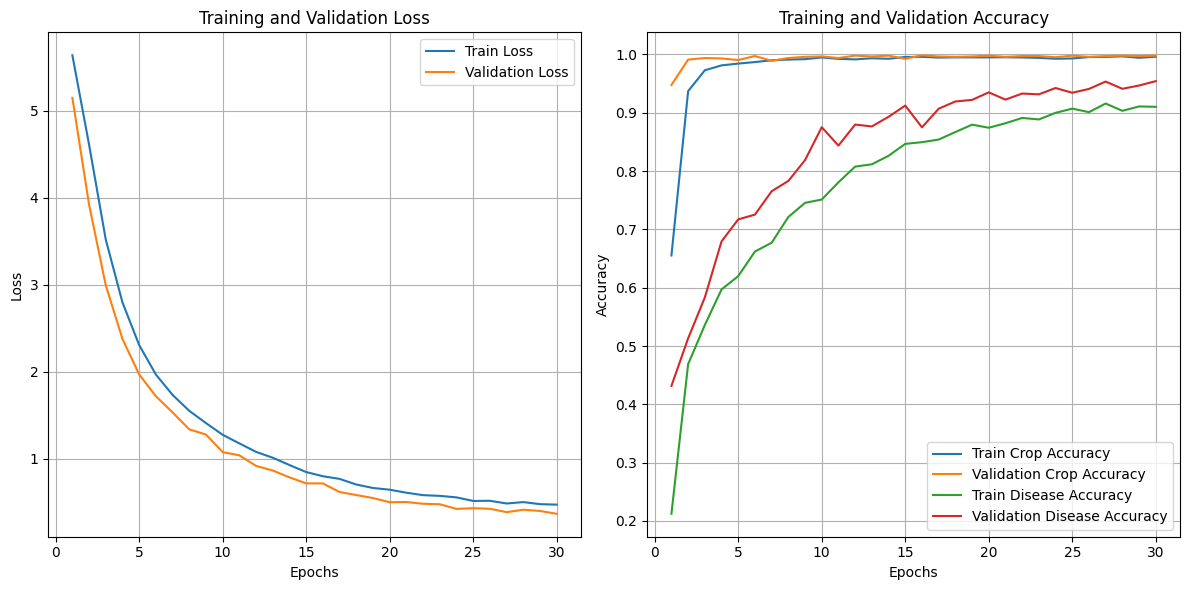

In [65]:
import matplotlib.pyplot as plt

def plot_training_history(training_history):
    """Plot loss and accuracy from training history for crop and disease tasks."""
    epochs = range(1, len(training_history['train_loss']) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_history['train_loss'], label='Train Loss')
    plt.plot(epochs, training_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracies
    train_crop_acc = [metrics['crop_acc'] for metrics in training_history['train_metrics']]
    val_crop_acc = [metrics['crop_acc'] for metrics in training_history['val_metrics']]
    train_disease_acc = [metrics['disease_acc'] for metrics in training_history['train_metrics']]
    val_disease_acc = [metrics['disease_acc'] for metrics in training_history['val_metrics']]

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_crop_acc, label='Train Crop Accuracy')
    plt.plot(epochs, val_crop_acc, label='Validation Crop Accuracy')
    plt.plot(epochs, train_disease_acc, label='Train Disease Accuracy')
    plt.plot(epochs, val_disease_acc, label='Validation Disease Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the plotting function with the history dictionary
plot_training_history(history)


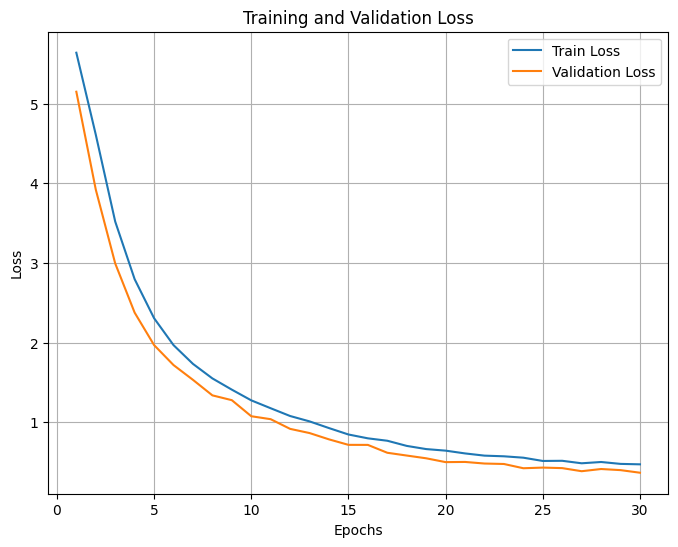

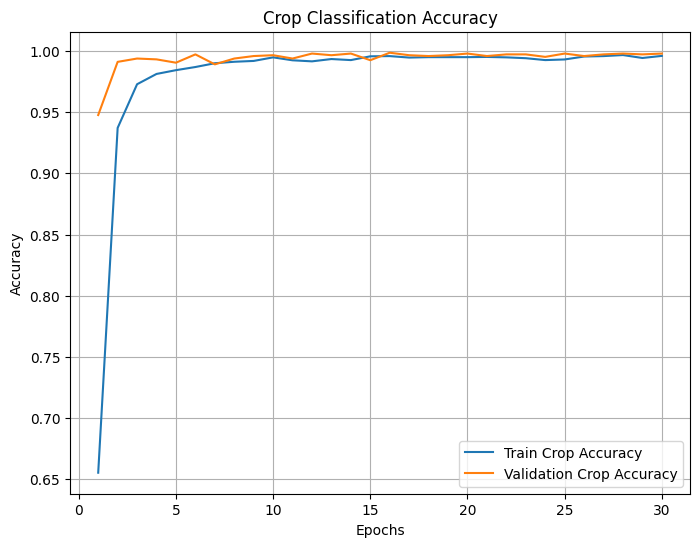

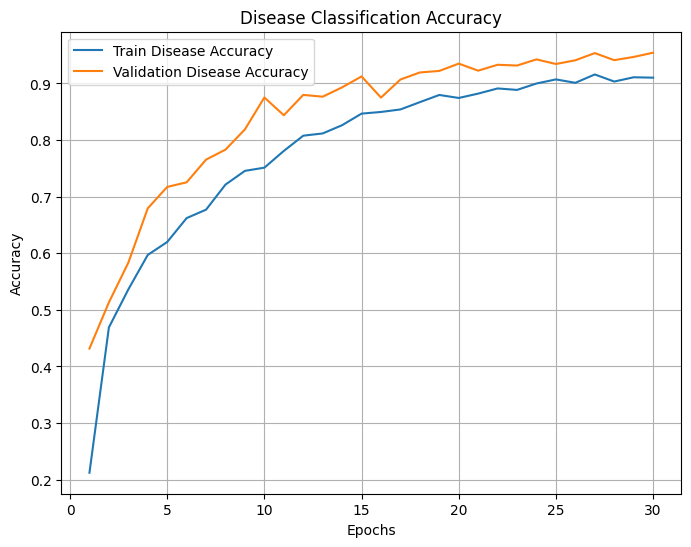

In [66]:
import matplotlib.pyplot as plt

def plot_separate_training_history(training_history):
    """Plot separate loss and accuracy metrics for crop and disease tasks."""
    epochs = range(1, len(training_history['train_loss']) + 1)

    # Plot Losses
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_history['train_loss'], label='Train Loss')
    plt.plot(epochs, training_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Crop Accuracy
    plt.figure(figsize=(8, 6))
    train_crop_acc = [metrics['crop_acc'] for metrics in training_history['train_metrics']]
    val_crop_acc = [metrics['crop_acc'] for metrics in training_history['val_metrics']]
    plt.plot(epochs, train_crop_acc, label='Train Crop Accuracy')
    plt.plot(epochs, val_crop_acc, label='Validation Crop Accuracy')
    plt.title('Crop Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Disease Accuracy
    plt.figure(figsize=(8, 6))
    train_disease_acc = [metrics['disease_acc'] for metrics in training_history['train_metrics']]
    val_disease_acc = [metrics['disease_acc'] for metrics in training_history['val_metrics']]
    plt.plot(epochs, train_disease_acc, label='Train Disease Accuracy')
    plt.plot(epochs, val_disease_acc, label='Validation Disease Accuracy')
    plt.title('Disease Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Call the function with the training history dictionary
plot_separate_training_history(history)


# EVALUATION

In [67]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
from tqdm import tqdm
import os


class ModelEvaluator:
    """Evaluates model performance across different test sets."""

    def __init__(self, model: torch.nn.Module, device: torch.device):
        self.model = model
        self.device = device
        self.model.eval()

    def evaluate_dataset(
        self,
        loader: torch.utils.data.DataLoader,
        dataset_name: str
    ) -> Dict[str, float]:
        """Evaluate model on a single dataset."""
        all_crop_preds = []
        all_disease_preds = []
        all_crop_labels = []
        all_disease_labels = []

        with torch.no_grad():
            for batch in tqdm(loader, desc=f"Evaluating {dataset_name}"):
                # Move data to device
                images = batch['image'].to(self.device)
                labels = {
                    'crop_label': batch['crop_label'].to(self.device),
                    'disease_label': batch['disease_label'].to(self.device),
                }

                # Forward pass
                outputs = self.model(images)

                # Get predictions
                crop_preds = outputs['crop_preds'].argmax(dim=1)
                disease_preds = outputs['disease_preds'].argmax(dim=1)

                # Store predictions and labels
                all_crop_preds.extend(crop_preds.cpu().numpy())
                all_disease_preds.extend(disease_preds.cpu().numpy())
                all_crop_labels.extend(labels['crop_label'].cpu().numpy())
                all_disease_labels.extend(labels['disease_label'].cpu().numpy())

        # Convert to numpy arrays
        predictions = {
            'crop': np.array(all_crop_preds),
            'disease': np.array(all_disease_preds),
        }

        ground_truth = {
            'crop': np.array(all_crop_labels),
            'disease': np.array(all_disease_labels),
        }

        # Calculate metrics
        metrics = {}
        for task in ['crop', 'disease']:
            metrics[f'{task}_acc'] = (predictions[task] == ground_truth[task]).mean()

            # Generate confusion matrix
            self.plot_confusion_matrix(
                ground_truth[task],
                predictions[task],
                f"{dataset_name}_{task}_confusion.png",
                f"{task.capitalize()} Classification"
            )

        return metrics

    @staticmethod
    def plot_confusion_matrix(
        true_labels: np.ndarray,
        pred_labels: np.ndarray,
        save_path: str,
        title: str
    ) -> None:
        """Plot and save confusion matrix."""
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{title} Confusion Matrix")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(save_path)
        plt.close()

    @staticmethod
    def calculate_harmonic_mean(seen_acc: float, unseen_acc: float) -> float:
        """Calculate harmonic mean between seen and unseen accuracies."""
        return 2 * (seen_acc * unseen_acc) / (seen_acc + unseen_acc)

def evaluate_model(
    model: torch.nn.Module,
    loaders: Dict,
    device: torch.device,
    save_dir: str = 'evaluation_results'
) -> Dict[str, float]:
    """
    Evaluate model performance across all test sets.
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)

    # Initialize evaluator
    evaluator = ModelEvaluator(model, device)

    # Evaluate on all test sets
    results = {}
    for dataset in ['test_seen', 'test_unseen']:
        results[dataset] = evaluator.evaluate_dataset(
            loaders[dataset],
            dataset
        )

    # Calculate harmonic means
    harmonic_means = {}
    for task in ['crop', 'disease']:
        harmonic_means[task] = evaluator.calculate_harmonic_mean(
            results['test_seen'][f'{task}_acc'],
            results['test_unseen'][f'{task}_acc']
        )

    # Print results
    print("\nEvaluation Results:")
    for dataset, metrics in results.items():
        print(f"\n{dataset.upper()}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    print("\nHarmonic Means (Seen vs Unseen):")
    for task, h_mean in harmonic_means.items():
        print(f"{task}: {h_mean:.4f}")

    return results, harmonic_means

def run_evaluation():
    # Configuration
    config = {
        'image_size': 224,
        'batch_size': 32,
        'num_workers': 4,
        'val_size': 0.15,
        'seed': 42
    }

    # Replace with actual datasets
    test_datasets = {
        'test_seen': processed_datasets['test_seen'],
        'test_unseen': processed_datasets['test_unseen']
    }

    # Use the filtered datasets with DatasetBuilder
    datasets = DatasetBuilder.create_datasets(test_datasets, transforms_dict)

    # Create loaders
    loaders = DataLoaderBuilder.create_loaders(
        datasets=datasets,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        pin_memory=True
    )

    # Load the best model
    model = SimplifiedCompZSLNet(
        num_crops=14,
        num_diseases=21,
        num_compositions=37,
        feature_dim=256,
        temperature=0.1
    ).to(device)

    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Run evaluation
    results, harmonic_means = evaluate_model(
        model=model,
        loaders=loaders,
        device=device,
        save_dir='evaluation_results'
    )

    return results, harmonic_means

# Run evaluation
if __name__ == "__main__":
    results, harmonic_means = run_evaluation()


-------------------- test_seen Dataset Statistics --------------------
Total samples: 1836

Crop Distribution:
Unique crops: 14
Samples per crop - Min: 50, Max: 500, Mean: 131.14

Top 5 crops by frequency:
crop
13    500
0     200
4     200
3     200
8     136
Name: count, dtype: int64

Disease Distribution:
Unique diseases: 21
Samples per disease - Min: 50, Max: 586, Mean: 87.43

Top 5 diseases by frequency:
disease
0     586
2     100
4     100
12    100
11    100
Name: count, dtype: int64

Unique crop-disease combinations: 37

Top 5 crop-disease combinations:
crop  disease
0     0          50
      1          50
      2          50
      3          50
1     0          50
dtype: int64

-------------------- Unseen Test Dataset Statistics --------------------
Total samples: 50

Unique crops: 1
Unique diseases: 1
Unique crop-disease combinations: 1

Distribution Summary:
Crops per sample: 1
Diseases per sample: 1
Average samples per combination: 50.00

Verifying dataset splits...
Test 

Evaluating test_unseen: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]



Evaluation Results:

TEST_SEEN:
crop_acc: 0.9907
disease_acc: 0.9510

TEST_UNSEEN:
crop_acc: 0.9800
disease_acc: 0.6600

Harmonic Means (Seen vs Unseen):
crop: 0.9853
disease: 0.7792
